# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [37]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
# magic word for producing visualizations in notebook
%matplotlib inline

In [3]:
# sagemaker libraries
import boto3
import sagemaker

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [1]:
!sudo sysctl vm.drop_caches=3

vm.drop_caches = 3


## Step 1: Exploratory Data Analysis (EDA)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [5]:
# load in the data
azdias = pd.read_csv('s3://datateam-ml/Arvato_project/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('s3://datateam-ml/Arvato_project/Udacity_CUSTOMERS_052018.csv', sep=';')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
#from the warning above, it's worth noting that the columns should be investigated
print(azdias.iloc[:,[18,19]].columns)
print(customers.iloc[:,[18,19]].columns)

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')
Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


## Step 1.1: Data Exploration, Missing Values, etc

In [9]:
#From here, it appears 'X' is found in the column which messes up the datatype
#Further investigation shows that the CAMEO_INTL_2015 attribute has 'XX' in it as well
azdias['CAMEO_DEUG_2015'].value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

In [6]:
#Create a copy of the dataset to avoid too frequent changes in the original
data1 = azdias.copy()
data2 = customers.copy()

In [45]:
data1.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [46]:
data2.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [11]:
#By getting the shape, the customers dataset has 3 more columns than the Azdias Dataset
data1.shape, data2.shape

((891221, 366), (191652, 369))

In [12]:
# The three differentiating columns between the Azdias and Customers datasets
list(set(data2.columns.tolist()) - set(data1.columns.tolist()))

['ONLINE_PURCHASE', 'CUSTOMER_GROUP', 'PRODUCT_GROUP']

In [10]:
#Drop the columns so both dataframes can have the same number of columns
data2 = data2.drop(['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'], axis=1)

In [14]:
#Now the shape of both dataframes are the same
data1.shape, data2.shape

((891221, 366), (191652, 366))

In [15]:
from preprocessing import clean_data
#Using the clean class for the general population dataset
clean1 = clean_data(data1)

#Using the clean class for the customer dataset
clean2 = clean_data(data2)

In [16]:
%%capture
nan_values1 = clean1.check_nan_before()
nan_values2 = clean2.check_nan_before()

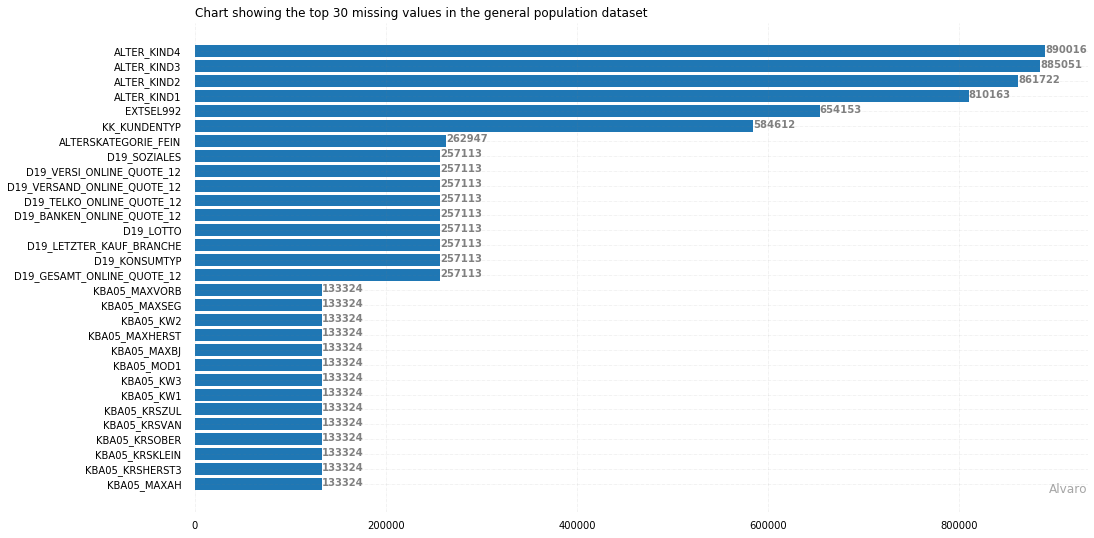

In [17]:
clean1.plot_nan(nan_values1)

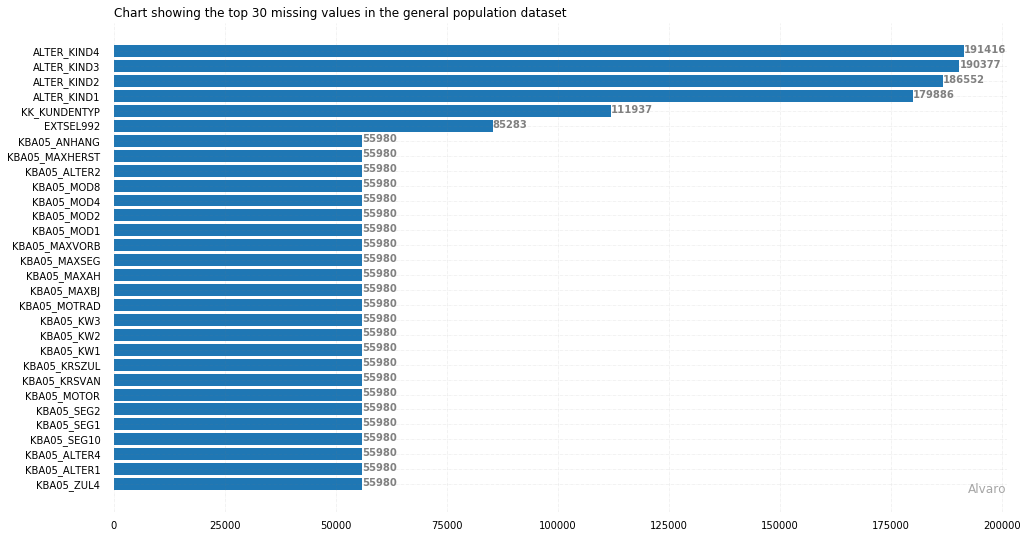

In [18]:
clean2.plot_nan(nan_values2)

## Step 1.2: Data Pre-processing

In [7]:
from preprocessing import clean_data
#Using the clean class for the general population dataset
clean3 = clean_data(data1)

#Using the clean class for the customer dataset
clean4 = clean_data(data2)

In [11]:
#Identify the column type in the general population dataset
clean3.identify_columns()


 CAMEO_DEU_2015 has a relatively low cardinality. It has 45 unique attributes

 CAMEO_DEUG_2015 has a relatively low cardinality. It has 19 unique attributes

 CAMEO_INTL_2015 has a relatively low cardinality. It has 43 unique attributes

 D19_LETZTER_KAUF_BRANCHE has a relatively low cardinality. It has 35 unique attributes

 EINGEFUEGT_AM has a high cardinality. It has 5162 unique attributes

 OST_WEST_KZ has a binary classification with 2 unique attributes


In [12]:
#Identify the column type in the customer dataset
clean4.identify_columns()


 CAMEO_DEU_2015 has a relatively low cardinality. It has 45 unique attributes

 CAMEO_DEUG_2015 has a relatively low cardinality. It has 19 unique attributes

 CAMEO_INTL_2015 has a relatively low cardinality. It has 43 unique attributes

 D19_LETZTER_KAUF_BRANCHE has a relatively low cardinality. It has 35 unique attributes

 EINGEFUEGT_AM has a high cardinality. It has 3034 unique attributes

 OST_WEST_KZ has a binary classification with 2 unique attributes

 PRODUCT_GROUP has a relatively low cardinality. It has 3 unique attributes

 CUSTOMER_GROUP has a binary classification with 2 unique attributes


In [13]:
%%capture
nan_values3 = clean3.check_nan_after()
nan_values4 = clean4.check_nan_after()

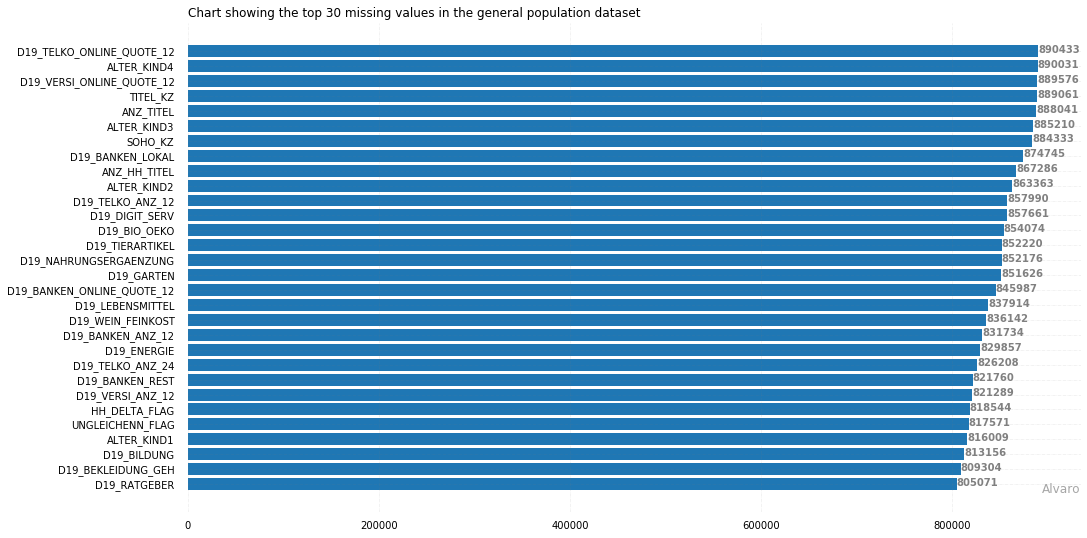

In [14]:
# The NaN values plotted here are values derived after adding unknown
# and missing values (0, -1, 9) to the other NaN values for the Azdias Dataset
clean3.plot_nan(nan_values3)

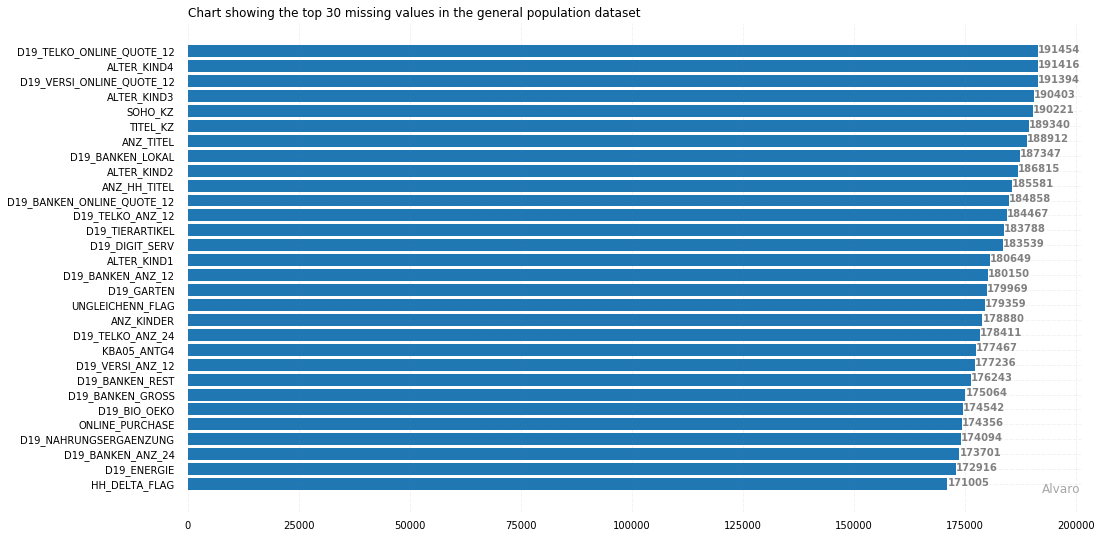

In [15]:
# The NaN values plotted here are values derived after adding unknown
# and missing values(0, -1, 9) to the other NaN values for the Customer Dataset
clean4.plot_nan(nan_values4)

## Step 1.3: Data Engineering and Cleaning

In [52]:
#This step uses the engineering and handle NaN methods in the preprocessing class
#The NaN values are dropped using a threshold of 30%
%%capture
processed_azdias = clean3.handle_nan()
processed_customers = clean4.handle_nan()

In [33]:
#After the preprocessing and engineering, 8 columns were no longer the same across
#the azdias and customers dataset
processed_azdias.shape, processed_customers.shape

((891221, 303), (191652, 311))

In [54]:
list(set(processed_customers.columns.tolist()) - set(processed_azdias.columns.tolist()))

['D19_VERSAND_ANZ_12',
 'VHA',
 'D19_TECHNIK',
 'AGER_TYP',
 'D19_SOZIALES',
 'EXTSEL992',
 'GREEN_AVANTGARDE',
 'D19_HAUS_DEKO']

In [58]:
#Drop the columns for the customers dataset to ensure consistency
processed_customers = processed_customers.drop(['D19_VERSAND_ANZ_12',
 'VHA',
 'D19_TECHNIK',
 'AGER_TYP',
 'D19_SOZIALES',
 'EXTSEL992',
 'GREEN_AVANTGARDE',
 'D19_HAUS_DEKO'], axis=1)

In [59]:
#Here the shape is back to the same and columns are identical across board
processed_azdias.shape, processed_customers.shape

((891221, 303), (191652, 303))

In [77]:
list(set(processed_customers.columns.tolist()) - set(processed_azdias.columns.tolist()))

[]

In [73]:
#Dropped columns after changing -1, 0, 9 to NaN and dropping NaN values with threshold 0.3 and 80
dropped_columns = ['AGER_TYP', 'D19_VERSI_ANZ_12', 'D19_TELKO_MOBILE', 'D19_BEKLEIDUNG_GEH', 'D19_FREIZEIT',
       'D19_TECHNIK', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_KINDERARTIKEL', 'D19_TELKO_REST', 
       'D19_VERSAND_ONLINE_QUOTE_12', 'TITEL_KZ', 'ANZ_TITEL', 'D19_KOSMETIK', 'D19_BANKEN_GROSS', 
       'D19_DIGIT_SERV', 'D19_TIERARTIKEL', 'ALTER_KIND1', 'D19_BANKEN_REST', 'ALTER_KIND2', 'D19_SCHUHE', 
       'KBA05_ANTG4', 'D19_TELKO_ANZ_12', 'D19_NAHRUNGSERGAENZUNG', 'D19_VERSAND_ANZ_12', 'D19_BIO_OEKO', 
       'D19_DROGERIEARTIKEL', 'D19_BANKEN_ANZ_12', 'D19_TELKO_ONLINE_QUOTE_12', 'SOHO_KZ', 'D19_RATGEBER', 
       'ALTER_KIND3', 'D19_BANKEN_ONLINE_QUOTE_12', 'KONSUMZELLE', 'D19_LOTTO', 'D19_VERSAND_REST', 
       'D19_BANKEN_DIREKT', 'UNGLEICHENN_FLAG', 'D19_HANDWERK', 'D19_VERSI_ANZ_24', 'D19_LEBENSMITTEL', 
       'D19_BANKEN_LOKAL', 'GREEN_AVANTGARDE', 'D19_HAUS_DEKO', 'D19_GESAMT_ONLINE_QUOTE_12', 
       'D19_VERSI_ONLINE_QUOTE_12', 'D19_ENERGIE', 'D19_BEKLEIDUNG_REST', 'VHA', 'ANZ_HH_TITEL', 
       'D19_GARTEN', 'EXTSEL992', 'D19_VERSICHERUNGEN', 'D19_TELKO_ANZ_24', 'D19_SOZIALES', 'ANZ_KINDER',
       'HH_DELTA_FLAG', 'D19_WEIN_FEINKOST', 'ALTER_KIND4', 'D19_BILDUNG', 'D19_BANKEN_ANZ_24', 'KBA05_ANTG3', 
       'KBA05_SEG6']

In [74]:
len(dropped_columns)

63

### Step 1.4: Data Upload to Amazon s3

In [ ]:
#Upon completing the NaN detection, cleaning, data engineering, etc, the clean
#data was saved to s3 and loaded from there for the Segmentation report

In [ ]:
#To avoid running the scripts all over again each time the kernel shuts down,
#the processed data is stored on s3 for the Azdias Dataset
import s3fs
fs = s3fs.S3FileSystem()
out = 'processed_azdias1.csv'
bytes_to_write = processed_azdias.to_csv(None, sep=',').encode()
with fs.open("s3://datateam-ml/Arvato_project/{}".format(out), 'wb') as f:
    f.write(bytes_to_write)

In [ ]:
#To avoid running the scripts all over again each time the kernel shuts down,
#the processed data is stored on s3 for the Customers Dataset
import s3fs
fs = s3fs.S3FileSystem()
out = 'processed_customers1.csv'
bytes_to_write = processed_customers.to_csv(None, sep=',').encode()
with fs.open("s3://datateam-ml/Arvato_project/{}".format(out), 'wb') as f:
    f.write(bytes_to_write)

In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [5]:
#Load both Azdias and Customers Dataset stored in s3 for a fresh start
processed_azdias = pd.read_csv("s3://datateam-ml/Arvato_project/processed_azdias1.csv")
processed_customers = pd.read_csv("s3://datateam-ml/Arvato_project/processed_customers1.csv")

In [6]:
#To confirm once more if the shape remains the same
processed_azdias.shape, processed_customers.shape

((891221, 303), (191652, 303))

In [7]:
#Check if there are any Categorical columns in the dataset
processed_azdias.select_dtypes(exclude=[np.number]).columns

Index(['CAMEO_DEU_2015'], dtype='object')

In [8]:
azdias_dummies = pd.get_dummies(processed_azdias)

In [9]:
customers_dummies = pd.get_dummies(processed_customers)

In [10]:
#New shape of both Azdias and Customers Dataset after getting Dummies
azdias_dummies.shape, customers_dummies.shape

((891221, 347), (191652, 347))

In [11]:
azdias_dummies.index = azdias_dummies['LNR'].astype(str)
customers_dummies.index = customers_dummies['LNR'].astype(str)

In [12]:
#Upon further investigation, one of the new created columns had XX, those
#had to be dropped together with the LNR column since it's the index column 
azdias_dummies = azdias_dummies.drop(['CAMEO_DEU_2015_XX', 'LNR'], axis = 1)
customers_dummies = customers_dummies.drop(['CAMEO_DEU_2015_XX', 'LNR'], axis = 1)

In [13]:
#New shape after dropping LNR and XX columns
azdias_dummies.shape, customers_dummies.shape

((891221, 345), (191652, 345))

In [11]:
azdias_dummies.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BUCH_CD,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_SONSTIGE,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VOLLSORTIMENT,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KK_KUNDENTYP,KKK,KOMBIALTER,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,S

In [14]:
# scale numerical features into a normalized range

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# store them in this dataframe
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_dummies))
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_dummies))

# get same features and LNR indices for azdias
azdias_scaled.columns = azdias_dummies.columns
azdias_scaled.index = azdias_dummies.index

# get same features and LNR indices for customers
customers_scaled.columns = customers_dummies.columns
customers_scaled.index = customers_dummies.index

In [15]:
customers_scaled.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BUCH_CD,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_SONSTIGE,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VOLLSORTIMENT,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KK_KUNDENTYP,KKK,KOMBIALTER,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,S

### Step 2 PCA and KMEANS using Sagemaker

### Step 2.1: Principal Component Analysis and Dimensionality Reduction

Our data is 345-dimensional for both the Azdias and Customers dataset. Clustering algorithms rely on finding clusters in n-dimensional feature space. For higher dimensions, an algorithm like k-means has a difficult time figuring out which features are most important, and the result is, often, noisier clusters.


> Ultimately, wee want to find the features that help to separate and group data. We want to find features that cause the **most variance** in the dataset!

So, before I cluster this data, I’ll want to take a dimensionality reduction step. My aim will be to form a smaller set of features that will better help to separate our data. The technique I’ll use is called PCA or **principal component analysis**

## Dimensionality Reduction

PCA attempts to reduce the number of features within a dataset while retaining the “principal components”, which are defined as *weighted*, linear combinations of existing features that are designed to be linearly independent and account for the largest possible variability in the data! You can think of this method as taking many features and combining similar or redundant features together to form a new, smaller feature set.

I would be leveraging the built-in SageMaker model for PCA.


In [17]:
# To get started, it is necessary to get the right permissions.
#The IAM role given for this Notebook is Full Access
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::101063123548:role/service-role/AmazonSageMaker-ExecutionRole-20190718T170250


In [18]:
#This helps create a bucket in the same region of the Sagemaker notebook
#using the specified session above
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-eu-west-1-101063123548



In [19]:
# define location to store model artifacts for Azdias
prefix1 = 'azdias'

output_path_azdias='s3://{}/{}/'.format(bucket_name, prefix1)

print('Training artifacts will be uploaded to: {}'.format(output_path_azdias))

Training artifacts will be uploaded to: s3://sagemaker-eu-west-1-101063123548/azdias/


In [20]:
# define location to store model artifacts for customers
prefix2 = 'customers'

output_path_customers='s3://{}/{}/'.format(bucket_name, prefix2)

print('Training artifacts will be uploaded to: {}'.format(output_path_customers))

Training artifacts will be uploaded to: s3://sagemaker-eu-west-1-101063123548/customers/


In [21]:
#We would be starting with features - 1 attributes and optimize later on
#for the number of attributes to keep based on variance
N_COMPONENTS=344

In [22]:
# define a Sagemaker PCA model for Azdias
from sagemaker import PCA

pca_azdias = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path_azdias,
             num_components=N_COMPONENTS, 
             sagemaker_session=session)

In [23]:
# define a Sagemaker PCA model for Customers
from sagemaker import PCA

pca_customers = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path_customers,
             num_components=N_COMPONENTS, 
             sagemaker_session=session)

In [24]:
# convert azdias_scaled to np array
train_azdias_np = azdias_scaled.values.astype('float32')

# convert to RecordSet format required by Sagemaker for training
formatted_train_azdias = pca_azdias.record_set(train_azdias_np)

In [25]:
# convert customers_scaled to np array
train_customers_np = customers_scaled.values.astype('float32')

# convert to RecordSet format required by Sagemaker for training
formatted_train_customers = pca_customers.record_set(train_customers_np)

In [27]:
%%time

# train the PCA mode on the formatted data
pca_azdias.fit(formatted_train_azdias)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-15 07:06:43 Starting - Starting the training job......
2020-10-15 07:07:15 Starting - Launching requested ML instances...
2020-10-15 07:08:13 Starting - Preparing the instances for training.........
2020-10-15 07:09:34 Downloading - Downloading input data...
2020-10-15 07:10:05 Training - Downloading the training image..
2020-10-15 07:10:40 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[10/15/2020 07:10:28 INFO 139956717934400] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[10/15/2020 07:10:28 INFO 139956717934400] Merging with provided configuration from /opt/ml/input/config/hyperparameter

In [24]:
%%time

# train the PCA mode on the formatted data
pca_customers.fit(formatted_train_customers)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-15 05:50:20 Starting - Starting the training job...
2020-10-15 05:50:22 Starting - Launching requested ML instances......
2020-10-15 05:51:38 Starting - Preparing the instances for training.........
2020-10-15 05:53:00 Downloading - Downloading input data...
2020-10-15 05:53:43 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/15/2020 05:53:48 INFO 140217081599808] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[10/15/2020 05:53:48 INFO 140217081599808] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'345', u'mini_ba

In [51]:
# Get the name of the training job in the AWS console
training_job_name_azdias='pca-2020-10-12-11-19-43-423'

# where the model is saved, by default
model_key_azdias = os.path.join(prefix1, training_job_name_azdias, 'output/model.tar.gz')
print(model_key_azdias)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key_azdias, '/home/ec2-user/SageMaker/Bertelsmann_Arvato_Project/azdias_model_algo/model1.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf -C /home/ec2-user/SageMaker/Bertelsmann_Arvato_Project/azdias_model_algo/model1.tar.gz')
os.system('unzip /home/ec2-user/SageMaker/Bertelsmann_Arvato_Project/azdias_model_algo/model_algo-1')

azdias/pca-2020-10-12-11-19-43-423/output/model.tar.gz


2304

In [26]:
# Get the name of the training in the AWS console
training_job_name_customers='pca-2020-10-12-11-25-21-755'

# where the model is saved, by default
model_key_customers = os.path.join(prefix2, training_job_name_customers, 'output/model.tar.gz')
print(model_key_customers)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key_customers, '/home/ec2-user/SageMaker/Bertelsmann_Arvato_Project/customers_model_algo/model2.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf -C /home/ec2-user/SageMaker/Bertelsmann_Arvato_Project/customers_model_algo/model2.tar.gz')
os.system('unzip /home/ec2-user/SageMaker/Bertelsmann_Arvato_Project/customers_model_algo/model_algo-2')

customers/pca-2020-10-12-11-25-21-755/output/model.tar.gz


2304

## PCA Model Attributes

Three types of model attributes are contained within the PCA model.

* **mean**: The mean that was subtracted from a component in order to center it.
* **v**: The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model).
* **s**: The singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.
    
We are only interested in v and s. 

From s, we can get an approximation of the data variance that is covered in the first `n` principal components. The approximate explained variance is given by the formula: the sum of squared s values for all top n components over the sum over squared s values for _all_ components:

\begin{equation*}
\frac{\sum_{n}^{ } s_n^2}{\sum s^2}
\end{equation*}

From v, we can learn more about the combinations of original features that make up each principal component.

In [26]:
# The use of mxnet for loading the model artifact is for computational speed
import mxnet as mx

# loading the unzipped artifacts
pca_azdias_params = mx.ndarray.load('/home/ec2-user/SageMaker/Bertelsmann_Arvato_Project/azdias_model_algo/model_algo-1')

In [27]:
#Get the v and s component for the Azdias dataset using
#the model artifact saved
s_azdias=pd.DataFrame(pca_azdias_params['s'].asnumpy())
v_azdias=pd.DataFrame(pca_azdias_params['v'].asnumpy())

In [28]:
import mxnet as mx

# loading the unzipped artifacts
pca_customers_params = mx.ndarray.load('/home/ec2-user/SageMaker/Bertelsmann_Arvato_Project/customers_model_algo/model_algo-1')

In [29]:
#Get the v and s component for the Customer dataset
#using the model artifact saved
s_customers = pd.DataFrame(pca_customers_params['s'].asnumpy())
v_customers = pd.DataFrame(pca_customers_params['v'].asnumpy())

In [30]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  ## 344-100 = 30, for example
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]

In [35]:
# test cell

n_top_components = 100 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s_customers, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.8141463


In [36]:
# test cell
n_top_components = 100 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s_azdias, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.81347454


In [ ]:
# From the cell above, it is obvious that setting both the azdias and customers
#top components to 100 gives approximately 81% of the variance

In [32]:
azdias_list = azdias_scaled.columns.values
customers_list = customers_scaled.columns.values

In [33]:
#The function here helps to display the component makeup of each attribute
#based on weightings of the original features. They are arranged from
#the smalles to the largest.

import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

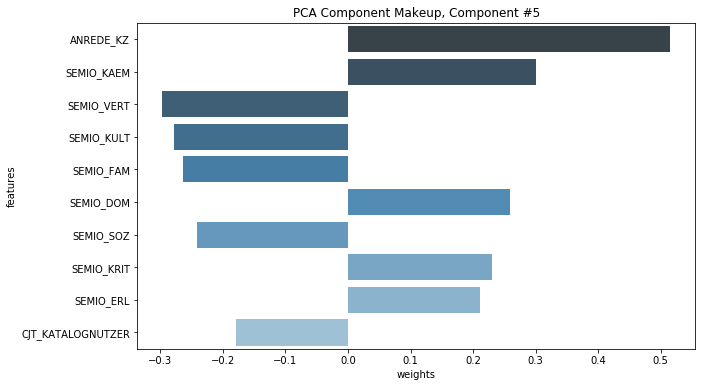

In [34]:
#Displaying top components for the Azdias Dataset
num=5
display_component(v_azdias, azdias_list, component_num=num, n_weights=10)

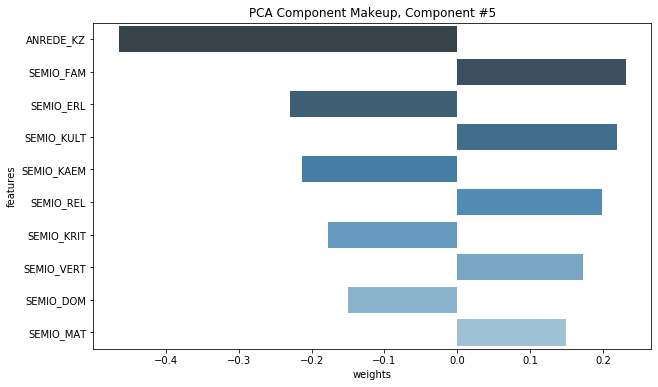

In [35]:
#Displaying top components for the Azdias Dataset
num=5
display_component(v_customers, customers_list, component_num=num, n_weights=10)

Something worth noting in the charts above is that some attributes have positive weightings for the Azdias dataset
and negative weightings for the customer dataset. Majority of these attributes still make up the top n components

In [30]:
#Next step is to deploy the PCA model 
%%time
# this takes a little while, around 7mins
pca_predictor_azdias = pca_azdias.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!CPU times: user 289 ms, sys: 17.2 ms, total: 306 ms
Wall time: 7min 33s


In [36]:
pca_predictor_customers = pca_customers.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!

In [96]:
pca_predictor_azdias

In [45]:
pca_predictor_customers

## Notable issues to highlight

Upon deploying the PCA model, the next step is to use the endpoint to predict the top compenents which would eventually
be stored as a dataframe and be used as the new features before fitting a KMEANS model. Here are some issues experienced:

- The API couldn't take above 4000 requests. It breaks once the request exceeds that.
- The output of the API predictions had a format (Sagemaker output format) which was altered because I had to write to a new list. Getting the required data out of the list was challenging.

In [31]:
#The function here helps to chunk the size of the list
#which is reusable for both Azdias and Customers
def chunks(l, n):
    
    """Yield successive n-sized chunks from l."""
    
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [44]:
MAX_API_BATCH_SIZE = 4000
train_pca_customers = []
for batch in chunks(train_customers_np, MAX_API_BATCH_SIZE):
    batch_done = pca_predictor_customers.predict(np.array(batch))
    train_pca_customers.append(batch_done)

In [45]:
new_list_customers = []
for i in range(0,len(train_pca_customers)):
    for data in train_pca_customers[i]:
            # get component values for each data point
        components=data.label['projection'].float32_tensor.values
        new_list_customers.append((components))

In [55]:
customers_df = pd.DataFrame(new_list_customers)
customers_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343
0,3.408948e-15,-0.000025,-0.000369,-0.000200,-0.006036,-0.009587,0.003311,-0.000663,0.004816,0.047199,-0.011474,-0.005389,0.013365,-0.018960,0.011068,-0.020637,-0.000207,-0.040218,0.026209,-0.002873,-0.080525,0.066348,-0.073786,0.011249,0.016708,0.148602,-0.028649,-0.026557,-0.048752,-0.015917,-0.147136,0.078714,-0.077804,0.140546,-0.024132,-0.052488,0.057911,0.040173,0.006152,-0.047369,-0.015996,0.017559,0.012613,-0.001002,-0.004830,0.028665,0.074708,0.122680,-0.096482,-0.108539,0.067206,0.078296,-0.010927,-0.010764,0.026937,-0.006712,0.004439,-0.035258,0.027792,-0.060335,0.022522,0.106720,0.027845,-0.056445,-0.056252,0.010935,-0.078144,0.141307,0.039059,-0.028432,-0.043129,-0.031239,0.036481,0.076162,0.011366,-0.007153,-0.079813,-0.109259,-0.089034,0.022187,0.068119,0.036615,0.012566,-0.134869,-0.063408,-0.055222,0.053096,-0.032267,-0.049907,-0.050507,-0.037399,-0.017445,-0.007816,-0.013439,0.084628,0.028917,0.083740,0.049320,-0.035160,0.113965,0.035257,0.042846,0.030669,-0.003758,0.061845,-0.008469,-0.036767,0.028395,-0.048753,0.000380,-0.037003,-0.023853,0.052765,-0.094530,0.014272,0.048323,0.011204,-0.041191,-0.117541,0.005348,0.020573,-0.144209,-0.060808,0.007860,-0.087344,-0.024630,-0.185682,-0.014399,0.011625,0.065411,-0.095291,0.023657,-0.086005,0.173110,-0.097616,0.027193,0.046046,0.024856,-0.054575,0.045110,-0.024776,0.214231,0.043793,0.126438,0.190790,-0.117840,-0.066625,0.105758,0.069081,-0.017495,-0.103562,0.081015,-0.022678,0.020390,-0.079802,0.009994,-0.058712,-0.127432,0.262194,0.137622,-0.172409,0.280648,-0.168189,-0.048372,-0.060612,-0.094220,0.029865,-0.195400,-0.043358,0.055908,-0.011731,0.084908,-0.019596,-0.161688,-0.041034,-0.054698,0.372983,-0.314385,-0.234961,0.432522,-0.250432,0.032075,-0.108635,-0.002960,-0.095636,0.168006,0.013104,0.254713,0.057065,-0.066520,0.144620,-0.237942,-0.193290,-0.139912,0.014870,-0.240725,0.391666,-0.071950,0.110622,-0.348549,0.308085,-0.042089,0.120204,-0.050054,-0.194754,-0.167986,-0.304290,0.108742,-0.095530,0.223996,-0.085934,0.029649,0.112179,0.007855,0.186904,0.034596,0.087541,0.222804,0.019095,-0.161231,-0.174384,-0.169070,0.100671,-0.177461,0.150964,0.006135,0.285148,0.341967,0.128801,0.208587,-0.105496,0.012465,0.328959,0.020000,-0.261331,0.119040,-0.137042,0.317391,-0.000208,0.306149,0.415285,-0.056054,-0.305362,-0.225642,-0.109169,0.097151,-0.152738,0.265829,0.087927,-0.114197,-0.260034,0.179710,0.230016,0.257147,0.177129,-0.283089,0.122668,0.118220,-0.154138,0.050689,-0.188677,0.209924,-0.401234,0.337000,0.050853,0.140743,-0.245870,-0.323144,-0.280674,-0.484010,0.083695,-0.219744,0.243647,0.134589,-0.114593,-0.394906,-0.469050,0.391986,0.081595,0.018643,-0.247005,-0.004570,-0.080906,-0.228958,0.374340,0.267590,-0.0804

In [57]:
# The new data with the new principal components were reindexed and save to a CSV
#which was subsequently pushed to s3
customers_df.index = customers_scaled.index

start_idx = N_COMPONENTS - 100
customers_df = customers_df.iloc[:,start_idx:]
        
customers_df.iloc[:, ::-1].to_csv("customers_transformed.csv")

In [ ]:
#To avoid running the scripts all over again each time the kernel shuts down,
#the transformed data is stored on the local machine and on s3 for the Customers Dataset

!aws s3 cp customers_transformed.csv s3://datateam-ml/Arvato_project/customers_transformed.csv -R

In [33]:
#Repeated the same steps for Azdias dataset as well
MAX_API_BATCH_SIZE = 4000
train_pca_azdias = []
for batch in chunks(train_azdias_np, MAX_API_BATCH_SIZE):
    batch_done = pca_predictor_azdias.predict(np.array(batch))
    train_pca_azdias.append(batch_done)

In [34]:
new_list_azdias = []
for i in range(0,len(train_pca_azdias)):
    for data in train_pca_azdias[i]:
            # get component values for each data point
        components=data.label['projection'].float32_tensor.values
        new_list_azdias.append((components))

In [35]:
MAX_API_BATCH_SIZE = 100000

azdias_df = pd.DataFrame()
c=0
for batch in chunks(new_list_azdias, MAX_API_BATCH_SIZE):
    
    z = pd.DataFrame(batch)
    azdias_df = pd.concat([azdias_df, z])
    c += 1
    
    print(c)
    

1
2
3
4
5
6
7
8
9


In [41]:
azdias_df.shape

(891221, 100)

In [40]:
azdias_df.head()

,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
910215.0,0.013498,0.042257,-0.119504,0.076330,0.043986,-0.083956,0.068182,0.043469,-0.017237,0.034453,-0.012856,-0.010926,0.006696,-0.138388,-0.118495,0.101862,-0.111774,0.012515,0.067082,0.083475,0.036825,0.007464,0.032747,0.012478,0.005508,-0.221525,-0.083079,-0.048552,-0.246426,-0.011076,-0.014920,-0.192476,0.027315,0.085765,0.199478,-0.239743,-0.070226,-0.007966,0.313061,0.137067,0.018006,-0.032614,-0.247599,0.222062,-0.070091,0.080673,-0.438217,-0.370220,-0.162628,0.145550,0.264807,0.553771,0.003010,0.019999,0.324382,-0.032886,0.413323,0.186741,-0.044705,-0.130595,-0.058439,-0.265247,0.027613,0.145261,0.042058,-0.083748,0.033175,-0.164803,0.087948,-0.233254,-0.074379,-0.044835,0.171337,0.058679,0.017103,0.122106,-0.076684,0.313281,-0.045201,-0.115052,0.159342,0.124536,-0.121533,-0.120684,-0.186847,0.229206,-0.070443,0.500092,-0.653248,-1.032859,-0.098073,0.487126,-0.317509,0.170602,0.277794,-0.132051,0.834974,0.056257,0.647302,0.128050
910220.0,0.133058,0.334784,-0.357446,0.216811,0.028676,-0.642065,0.273506,-0.464677,0.033430,-0.465940,-0.013344,-0.033816,-0.178568,0.891962,0.073703,-0.176319,0.023343,0.336847,-0.392295,0.114227,0.005821,0.069863,-0.019316,-0.029027,0.063040,-0.136972,0.267667,0.153546,0.865031,0.112258,0.414007,0.109022,-0.189976,-0.358425,0.207937,-0.314596,0.324419,0.113365,-0.413572,0.140396,0.263425,0.465376,-0.437382,-0.392457,-0.495510,0.132898,-0.321506,0.175463,0.133595,-0.489060,0.003638,-0.206608,-0.343449,0.022166,0.169695,0.547203,0.108170,0.404424,-0.713694,0.440420,0.066378,-0.126300,0.364146,-0.003040,0.396407,0.070589,-0.000859,0.105357,-0.418254,-0.295463,-0.982516,0.173571,0.411660,-0.227215,0.138987,-0.230009,0.523820,-0.613208,0.192247,-0.195553,-0.291707,0.156838,0.991737,-0.652107,0.562089,0.673075,0.419605,-0.668416,0.220082,-0.116511,-1.141556,-0.580190,-0.079231,-1.095114,-0.368640,0.528020,1.065541,-1.025107,-1.613828,1.727933
910225.0,-0.353626,0.203822,-0.385134,-0.256355,0.081521,0.200832,-0.217285,0.063784,0.001905,-0.111132,-0.056274,0.007352,0.121220,0.264360,-0.343592,0.000037,0.084160,-0.194162,-0.105756,-0.117679,-0.238616,-0.405315,0.205723,0.363981,-0.207511,-0.280953,-0.427900,-0.287248,-0.135473,0.456223,-0.054104,-0.064230,0.035098,0.461573,0.007600,0.362666,-0.517075,-0.388700,-0.175461,0.049329,0.490502,-0.391675,-0.336928,0.314862,-0.124585,-0.387180,-0.146826,0.197877,-0.101099,0.485209,-0.000475,-0.199803,0.078194,-0.096059,-0.546795,-0.611931,-0.134708,-0.002540,0.282751,0.148749,0.252984,0.294659,0.067448,0.105440,-0.404199,-0.165616,-0.323402,-0.189615,-0.002622,-0.346853,-0.342255,-0.416182,0.194978,-0.337168,0.388478,-0.032162,0.182788,-0.001180,-0.786959,0.661355,-1.033646,0.235288,0.178198,0.404165,-0.517008,-0.392634,-0.096810,-0.381362,0.586895,0.473864,0.828526,-0.650152,1.042887,0.707886,1.452516,0.846047,1.046596,-1.023305,-0.724317,0.018004
910226.0,-0.113299,-0.068212,0.326831,-0.096542,0.021898,-0.091616,0.054726,0.212297,0.212119,-0.217325,-0.176063,-0.173831,-0.325827,0.143028,-0.459228,-0.178820,-0.223195,0.114941,-0.012404,0.022061,0.549637,0.300562,0.404837,-0.233940,-0.020858,0.712055,-0.132602,-0.353040,-0.030082,0.192073,-0.011694,0.038310,0.880140,0.055327,-0.276191,-0.184974,-0.126563,-0.509302,0.285907,-0.194205,-0.104612,-0.140863,0.081206,-0.375319,-0.156875,0.064563,-0.040499,0.215705,-0.730962,-0.265623,-0.292382,0.110922,-0.279570,-0.043715,0.156404,0.150191,-0.565204,-0.166839,-0.249496,0.283084,0.101589,-0.343161,-0.251860,-0.06165

In [39]:
azdias_df.index = azdias_scaled.index

start_idx = N_COMPONENTS - 100
azdias_df = azdias_df.iloc[:,start_idx:]
        
azdias_df.iloc[:, ::-1].to_csv("azdias_transformed.csv")

In [ ]:
#To avoid running the scripts all over again each time the kernel shuts down,
#the transformed data is stored on the local machine and on s3 for the Azdias Dataset

!aws s3 cp azdias_transformed s3://datateam-ml/Arvato_project/azdias_transformed -R

One way I ensured I didn't keep the endpoint running and also, record each milestone is by pushing the transformed data
to s3 bucket where subsequent steps can now pick up from there.

## KMEANS

In [6]:
#Loading the transformed dataset from Amazon s3
azdias_pca = pd.read_csv("s3://datateam-ml/Arvato_project/azdias_transformed.csv", index_col='LNR')
azdias_pca.head()

,343,342,341,340,339,338,337,336,335,334,333,332,331,330,329,328,327,326,325,324,323,322,321,320,319,318,317,316,315,314,313,312,311,310,309,308,307,306,305,304,303,302,301,300,299,298,297,296,295,294,293,292,291,290,289,288,287,286,285,284,283,282,281,280,279,278,277,276,275,274,273,272,271,270,269,268,267,266,265,264,263,262,261,260,259,258,257,256,255,254,253,252,251,250,249,248,247,246,245,244
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
910215.0,0.128050,0.647302,0.056257,0.834974,-0.132051,0.277794,0.170602,-0.317509,0.487126,-0.098073,-1.032859,-0.653248,0.500092,-0.070443,0.229206,-0.186847,-0.120684,-0.121533,0.124536,0.159342,-0.115052,-0.045201,0.313281,-0.076684,0.122106,0.017103,0.058679,0.171337,-0.044835,-0.074379,-0.233254,0.087948,-0.164803,0.033175,-0.083748,0.042058,0.145261,0.027613,-0.265247,-0.058439,-0.130595,-0.044705,0.186741,0.413323,-0.032886,0.324382,0.019999,0.003010,0.553771,0.264807,0.145550,-0.162628,-0.370220,-0.438217,0.080673,-0.070091,0.222062,-0.247599,-0.032614,0.018006,0.137067,0.313061,-0.007966,-0.070226,-0.239743,0.199478,0.085765,0.027315,-0.192476,-0.014920,-0.011076,-0.246426,-0.048552,-0.083079,-0.221525,0.005508,0.012478,0.032747,0.007464,0.036825,0.083475,0.067082,0.012515,-0.111774,0.101862,-0.118495,-0.138388,0.006696,-0.010926,-0.012856,0.034453,-0.017237,0.043469,0.068182,-0.083956,0.043986,0.076330,-0.119504,0.042257,0.013498
910220.0,1.727933,-1.613828,-1.025107,1.065541,0.528020,-0.368640,-1.095114,-0.079231,-0.580190,-1.141556,-0.116511,0.220082,-0.668416,0.419605,0.673075,0.562089,-0.652107,0.991737,0.156838,-0.291707,-0.195553,0.192247,-0.613208,0.523820,-0.230009,0.138987,-0.227215,0.411660,0.173571,-0.982516,-0.295463,-0.418254,0.105357,-0.000859,0.070589,0.396407,-0.003040,0.364146,-0.126300,0.066378,0.440420,-0.713694,0.404424,0.108170,0.547203,0.169695,0.022166,-0.343449,-0.206608,0.003638,-0.489060,0.133595,0.175463,-0.321506,0.132898,-0.495510,-0.392457,-0.437382,0.465376,0.263425,0.140396,-0.413572,0.113365,0.324419,-0.314596,0.207937,-0.358425,-0.189976,0.109022,0.414007,0.112258,0.865031,0.153546,0.267667,-0.136972,0.063040,-0.029027,-0.019316,0.069863,0.005821,0.114227,-0.392295,0.336847,0.023343,-0.176319,0.073703,0.891962,-0.178568,-0.033816,-0.013344,-0.465940,0.033430,-0.464677,0.273506,-0.642065,0.028676,0.216811,-0.357446,0.334784,0.133058
910225.0,0.018004,-0.724317,-1.023305,1.046596,0.846047,1.452516,0.707886,1.042887,-0.650152,0.828526,0.473864,0.586895,-0.381362,-0.096810,-0.392634,-0.517008,0.404165,0.178198,0.235288,-1.033646,0.661355,-0.786959,-0.001180,0.182788,-0.032162,0.388478,-0.337168,0.194978,-0.416182,-0.342255,-0.346853,-0.002622,-0.189615,-0.323402,-0.165616,-0.404199,0.105440,0.067448,0.294659,0.252984,0.148749,0.282751,-0.002540,-0.134708,-0.611931,-0.546795,-0.096059,0.078194,-0.199803,-0.000475,0.485209,-0.101099,0.197877,-0.146826,-0.387180,-0.124585,0.314862,-0.336928,-0.391675,0.490502,0.049329,-0.175461,-0.388700,-0.517075,0.362666,0.007600,0.461573,0.035098,-0.064230,-0.054104,0.456223,-0.135473,-0.287248,-0.427900,-0.280953,-0.207511,0.363981,0.205723,-0.405315,-0.238616,-0.117679,-0.105756,-0.194162,0.084160,0.000037,-0.343592,0.264360,0.121220,0.007352,-0.056274,-0.111132,0.001905,0.063784,-0.217285,0.200832,0.081521,-0.256355,-0.385134,0.203822,-0.353626
910226.0,-2.030178,0.493342,-0.080412,1.264966,0.252435,-0.161160,-0.739453,0.094562,0.674759,-0.247983,0.719552,0.652956,-0.691256,0.058651,-0.502860,0.081416,0.420540,-0.671524,-0.295057,0.710502,0.074378,-0.356549,0.499336,-0.306282,-0.007212,-0.439945,-0.079232,-0.033103,-0.382498,0.010502,0.418607,-0.273162,-0.218742,-0.450826,-1.027654,-0.273299,-0.061656,-0.251860,-0.343161,0.101589,0.283084,-0.249496,-0.166839,-0.565204,0.150191,0.156404,-0.043715,-0.279570,0.110922,-0.292382,-0.265623,-0.730962,0.215705,-0.040499,0.064563,-0.156875,-0.375319,0.081206,-0.140863,-0.104612,-0.194205,0.285907,-0.509302,-0.1265

In [7]:
customers_pca = pd.read_csv("s3://datateam-ml/Arvato_project/customers_transformed.csv", index_col='LNR')
customers_pca.head()

,343,342,341,340,339,338,337,336,335,334,333,332,331,330,329,328,327,326,325,324,323,322,321,320,319,318,317,316,315,314,313,312,311,310,309,308,307,306,305,304,303,302,301,300,299,298,297,296,295,294,293,292,291,290,289,288,287,286,285,284,283,282,281,280,279,278,277,276,275,274,273,272,271,270,269,268,267,266,265,264,263,262,261,260,259,258,257,256,255,254,253,252,251,250,249,248,247,246,245,244
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9626.0,-1.541254,0.635094,1.039238,-1.557987,0.054845,0.862390,0.438100,0.280956,0.032729,-0.495898,0.156246,-0.362068,0.568845,-0.073203,0.221583,-0.073049,-0.062827,-0.714352,-0.347606,0.406122,-0.480615,0.001393,0.216174,-0.476306,-0.795500,0.172504,-0.387555,-0.179940,0.185441,-0.323835,-0.069921,0.134657,-0.240522,-0.321296,-0.075183,0.098789,-0.226364,-0.017046,0.566393,0.115319,0.132856,-0.192226,0.447819,0.689844,-0.245021,-0.271462,-0.128842,0.077686,-0.033314,0.179080,-0.292631,-0.367976,0.523145,0.045708,0.230540,0.325338,0.214262,-0.080485,0.267590,0.374340,-0.228958,-0.080906,-0.004570,-0.247005,0.018643,0.081595,0.391986,-0.469050,-0.394906,-0.114593,0.134589,0.243647,-0.219744,0.083695,-0.484010,-0.280674,-0.323144,-0.245870,0.140743,0.050853,0.337000,-0.401234,0.209924,-0.188677,0.050689,-0.154138,0.118220,0.122668,-0.283089,0.177129,0.257147,0.230016,0.179710,-0.260034,-0.114197,0.087927,0.265829,-0.152738,0.097151,-0.109169
9628.0,-0.283086,-0.063341,0.154112,-0.497918,0.699325,0.355636,-0.035044,-0.128539,-0.163959,-0.223786,0.051511,-0.305325,0.522592,-0.078339,0.382302,0.117225,0.001778,-0.037010,0.098131,-0.150211,0.031230,0.083780,-0.146558,0.113122,0.010080,-0.019212,-0.117796,0.011346,-0.179654,0.062118,-0.002460,0.085899,-0.007824,0.090975,-0.013317,0.274624,-0.085147,0.191039,-0.024095,0.187961,0.231608,-0.047218,-0.087778,0.156992,-0.039387,0.067087,0.152054,-0.147984,-0.169271,-0.126299,-0.003783,0.089027,-0.144424,0.026914,0.029177,0.234352,0.098318,-0.223441,0.168251,0.042765,-0.038915,-0.036985,-0.009781,0.030058,-0.048521,0.096478,-0.365165,-0.233897,0.095617,-0.055060,-0.159539,-0.008035,-0.146365,-0.269866,0.116630,-0.131234,0.180474,0.065227,0.187328,-0.010746,-0.132199,0.012236,0.053815,-0.068175,0.196905,0.005100,-0.071537,0.018359,0.035496,0.057819,-0.016636,-0.002752,0.022677,-0.019243,0.009875,-0.024732,-0.063273,-0.124050,0.004382,0.030391
143872.0,0.540943,-1.661981,-0.050136,-0.925016,-0.721035,-0.415857,1.392586,0.454287,0.701500,-0.676622,-1.105615,0.175185,-0.491552,-1.084390,-0.389213,-0.418091,0.107955,0.798149,0.182408,-0.125945,-0.838026,-0.033710,-0.765520,0.357102,0.041011,-0.066680,0.379616,0.305769,-0.083540,-0.261519,0.042628,0.115354,-0.164022,-0.008487,0.267207,0.784417,-0.252238,0.078768,-0.295282,-0.423494,0.531860,-0.158304,-0.596606,-0.620370,-0.897181,0.072685,0.332054,0.208805,0.061778,0.464205,0.113904,-0.574903,-0.251345,0.209882,0.459797,-0.236695,-0.020372,0.170568,-0.322412,-0.608105,-0.557597,0.001035,0.032656,0.251030,0.043446,-0.209957,0.333722,-0.868875,0.504423,0.565237,0.464189,-0.210239,-0.019114,0.006161,-0.044969,-0.508948,0.182364,-0.307104,-0.288708,-0.368369,0.010473,0.130753,-0.399258,-0.337519,-0.028682,0.147345,-0.041275,-0.090031,0.032451,-0.117545,-0.117598,0.094098,-0.198949,0.273294,0.053763,-0.276484,0.031454,-0.192917,-0.136607,-0.166090
143873.0,-1.313677,0.540741,-0.704934,-1.019462,0.003822,0.895108,-0.672829,-0.064620,-0.733449,-0.050970,-0.711796,-0.107460,0.038814,0.392240,-0.198324,0.034538,-0.915784,-0.735851,-0.334482,0.199203,0.487250,0.108568,-0.270302,0.271578,0.386705,-0.247637,0.735656,0.398694,-0.285515,-0.113954,-0.221045,-0.735219,-0.151199,-0.416436,-0.140124,-0.512539,0.306025,-0.082171,-0.666793,-0.252109,-0.268512,0.484274,0.315049,-0.262160,-0.177204,0.310843,-0.066537,-0.277022,0.032327,-0.432427,-0.119120,-0.210128,-0.376549,-0.246397,0.024084,-0.395883,-0.222366,0.177021,0.118034,0.092305,-0.068751,0.451262,0.295322,-0

In [8]:
azdias_pca.shape, customers_pca.shape

((891221, 100), (191652, 100))

# To determine the K to use using the elbow method

In [9]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(customers_pca)
    distortions.append(kmeanModel.inertia_)

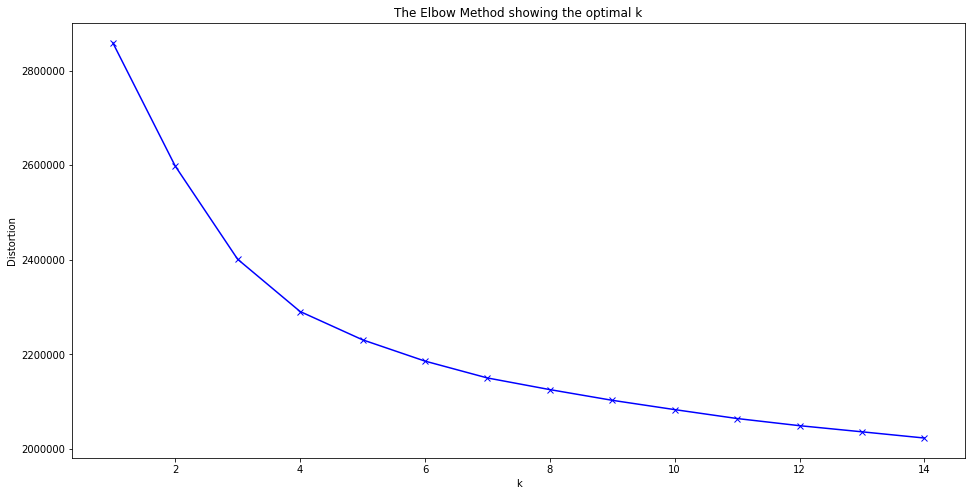

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k for the customer dataset')
plt.show()

From the image above, the curve takes a steep turn between k = 4 and k=6. From this, I will be leaning more towards picking a value of k=5

# Using the elbow method to determine the optimal k for the Azdias dataset

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(azdias_pca)
    distortions.append(kmeanModel.inertia_)

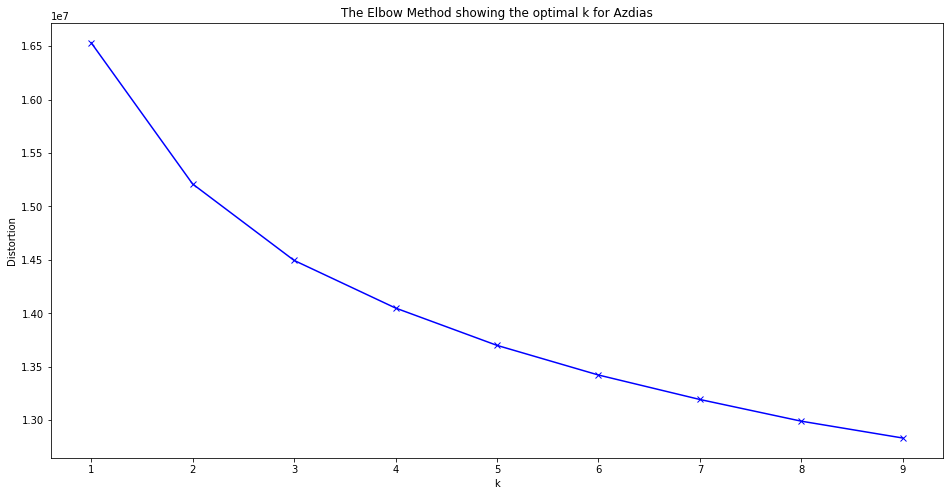

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k for Azdias')
plt.show()

Observing this curve as well, it appears a little bit different from the Customers curve, but we can observe a steep slope between k=3 and k=6. For consistency, I will lean more towards picking a value of 5 for k here as well.

## Using Sagemaker KMeans Estimator

A KMeans estimator requires a number of parameters to be instantiated such as the role, instance type and instance count, which allows us to specify the type of training instance to use, and the model hyperparameters(e.g the optimal k to use).

In [18]:
# define a KMeans estimator
from sagemaker import KMeans

NUM_CLUSTERS = 5

kmeans_customers = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=output_path_customers, # using the same output path as was defined, earlier              
                k=NUM_CLUSTERS)

In [19]:
# define a KMeans estimator
from sagemaker import KMeans

NUM_CLUSTERS = 5

kmeans_azdias = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=output_path_azdias, # using the same output path as was defined, earlier              
                k=NUM_CLUSTERS)

Before fitting the data on the KMeans estimator, it is necessary to convert the dataframes into a numpy array and also a record set to aid the performance of the model

In [20]:
kmeans_train_data_customers = customers_pca.values.astype('float32')
kmeans_formatted_data_customers = kmeans_customers.record_set(kmeans_train_data_customers)

In [21]:
kmeans_train_data_azdias = azdias_pca.values.astype('float32')
kmeans_formatted_data_azdias = kmeans_azdias.record_set(kmeans_train_data_azdias)

In [22]:
%%time
# train kmeans
kmeans_customers.fit(kmeans_formatted_data_customers)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-16 08:03:04 Starting - Starting the training job...
2020-10-16 08:03:07 Starting - Launching requested ML instances......
2020-10-16 08:04:06 Starting - Preparing the instances for training...
2020-10-16 08:04:52 Downloading - Downloading input data......
2020-10-16 08:05:59 Training - Training image download completed. Training in progress.
2020-10-16 08:05:59 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[10/16/2020 08:05:57 INFO 139994479310656] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_

In [23]:
%%time
# train kmeans
kmeans_azdias.fit(kmeans_formatted_data_azdias)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-16 08:07:59 Starting - Starting the training job...
2020-10-16 08:08:01 Starting - Launching requested ML instances......
2020-10-16 08:09:18 Starting - Preparing the instances for training......
2020-10-16 08:10:27 Downloading - Downloading input data...
2020-10-16 08:10:55 Training - Downloading the training image...
2020-10-16 08:11:25 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[10/16/2020 08:11:18 INFO 140305765320512] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_d

In [24]:
%%time
# deploy the model to create a predictor
kmeans_predictor_customers = kmeans_customers.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!CPU times: user 324 ms, sys: 16.2 ms, total: 340 ms
Wall time: 8min 33s


In [25]:
kmeans_predictor_azdias = kmeans_azdias.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

### Notable issues to highlight
Upon deploying the KMeans model, the next step is to use the endpoint to predict the clusters that each customer belong to. Here are some issues experienced:

- The API couldn't take above 4000 requests. It breaks once the request exceeds that.
- The output of the API predictions had a format (Sagemaker output format) which was altered because I had to write to a new list. Getting the required data out of the list was challenging.

# Customers clusters

In [30]:
def chunks(l, n):
    
    """Yield successive n-sized chunks from a list."""
    
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [31]:
#The API throws an error for requests that exceed 4000, so it was 
#necessary to chunk the requests

MAX_API_BATCH_SIZE = 4000
cluster_info_customers = []
for batch in chunks(kmeans_train_data_customers, MAX_API_BATCH_SIZE):
    batch_done = kmeans_predictor_customers.predict(np.array(batch))
    cluster_info_customers.append(batch_done)

In [33]:
cluster_label_customers = []
for i in range(0,len(cluster_info_customers)):
    for data in cluster_info_customers[i]:
            # get component values for each data point
        components=data.label['closest_cluster'].float32_tensor.values[0]
        cluster_label_customers.append((components))

In [41]:
cluster_df_customers = pd.DataFrame(cluster_label_customers)[0].value_counts()
print(cluster_df_customers)

3.0    52465
2.0    47540
1.0    36078
4.0    34957
0.0    20612
Name: 0, dtype: int64


# Azdias clusters

In [43]:
MAX_API_BATCH_SIZE = 4000
cluster_info_azdias = []
for batch in chunks(kmeans_train_data_azdias, MAX_API_BATCH_SIZE):
    batch_done = kmeans_predictor_azdias.predict(np.array(batch))
    cluster_info_azdias.append(batch_done)

In [44]:
cluster_label_azdias = []
for i in range(0,len(cluster_info_azdias)):
    for data in cluster_info_azdias[i]:
            # get component values for each data point
        components=data.label['closest_cluster'].float32_tensor.values[0]
        cluster_label_azdias.append((components))

In [46]:
cluster_df_azdias = pd.DataFrame(cluster_label_azdias)[0].value_counts()
print(cluster_df_azdias)

2.0    222919
0.0    184453
3.0    184024
4.0    170358
1.0    129467
Name: 0, dtype: int64


# Map the clusters to the customers and azdias dataset

In [47]:
# add a 'labels' column to the dataframe
customers_pca['labels']=list(map(int, cluster_label_customers))

# sort by cluster label 0-4
sorted_customers = customers_pca.sort_values('labels', ascending=True)
# view some pts in cluster 0
sorted_customers.head()

,343,342,341,340,339,338,337,336,335,334,333,332,331,330,329,328,327,326,325,324,323,322,321,320,319,318,317,316,315,314,313,312,311,310,309,308,307,306,305,304,303,302,301,300,299,298,297,296,295,294,293,292,291,290,289,288,287,286,285,284,283,282,281,280,279,278,277,276,275,274,273,272,271,270,269,268,267,266,265,264,263,262,261,260,259,258,257,256,255,254,253,252,251,250,249,248,247,246,245,244,labels
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
182060.0,-1.228520,-0.538319,1.747669,-0.838503,0.250587,0.101678,-0.901902,-0.485444,0.603394,-1.462854,0.266000,0.317449,-0.237855,-0.143282,0.602755,-0.047427,0.167640,0.616258,1.011198,-0.294821,-0.599674,-0.156138,0.505803,-0.611102,-0.183253,0.263181,0.141806,0.179506,0.160563,-0.128679,-0.347553,-0.325728,-0.011442,-0.038755,-0.321395,0.107231,-0.403109,0.215031,-0.211831,0.164798,0.107204,-0.131303,0.264575,-0.306227,0.189646,0.240895,0.099567,0.379222,-0.192933,0.363114,-0.422625,-0.026164,-0.112249,0.060457,0.154043,0.194052,0.261282,0.309429,-0.026032,0.299543,-0.327873,0.253925,0.247785,-0.112925,-0.245179,0.094112,-0.036550,-0.066654,-0.255233,0.049577,-0.019320,0.340959,0.298985,0.269714,0.031685,0.017160,0.060892,-0.163211,0.360942,-0.420531,-0.025152,-0.152794,-0.003761,0.469164,0.181126,0.091319,-0.036617,-0.177763,-0.157337,-0.302288,-0.195107,0.369463,0.097204,0.172167,-0.159067,0.041054,-0.041144,0.300059,0.165593,0.773558,0
164497.0,-0.997957,-1.167910,1.285846,-0.842893,0.146928,0.477868,0.339039,0.180128,0.724163,0.649809,0.263472,0.642531,-0.165615,0.256724,0.125584,0.176475,-0.303427,0.299137,-0.577045,0.411939,0.061045,0.506944,0.118692,-0.314957,-0.247107,0.846073,0.471259,0.504724,-0.042058,-0.277887,-0.077262,-0.007147,-0.376858,-0.195574,0.685450,-0.212184,0.572064,-0.102833,0.022114,0.144932,0.311289,0.015869,0.121771,-0.814015,0.476280,0.340550,-0.436854,0.175903,0.025249,-0.425397,0.346829,-0.446227,-0.360808,-0.064276,0.547177,-0.060106,0.097556,-0.636151,-0.326143,-0.526289,-0.127245,-0.187792,0.101636,-0.248289,-0.612798,0.100310,0.020467,0.136012,0.111313,-0.240677,-0.058426,0.144623,-0.315608,-0.234536,-0.040439,0.147204,0.251846,-0.021895,-0.247473,0.482589,0.276522,0.136341,0.048779,0.347838,0.160059,0.082396,0.183456,-0.533510,-0.062677,-0.303667,0.392571,-0.357494,0.132917,-0.327652,0.276520,0.185873,0.322328,-0.040552,-0.228779,0.103712,0
42697.0,-1.555475,-0.400070,1.369220,-1.091838,0.494645,0.318228,0.343232,0.161913,0.940027,-1.393106,0.570041,-0.908235,0.050227,-0.533936,-0.032834,0.065274,-0.134106,-0.001746,-0.162807,0.409378,0.030347,-0.442817,0.080698,-0.346908,0.223584,-0.125906,0.441318,0.377197,-0.087534,0.344697,-0.251201,-0.370866,0.160585,0.135138,-0.395876,-0.099609,0.278660,0.409025,-0.052320,0.905351,0.277448,0.220242,0.329265,0.455424,-0.113050,-0.069948,-0.146281,0.398482,0.120728,0.024665,-0.255436,0.112443,0.167027,-0.122702,0.539081,-0.077811,-0.038899,0.084085,-0.033234,-0.109446,0.422048,0.152783,-0.002234,-0.425688,-0.309289,-0.295377,0.059248,-0.335344,-0.529159,0.517586,0.031623,-0.070658,-0.064365,-0.080849,0.150358,0.063915,-0.334473,-0.091768,-0.321258,0.258982,-0.008939,-0.134136,0.337045,-0.292044,0.014545,0.196321,0.329668,0.101183,-0.030581,-0.170144,0.348122,-0.085909,0.015008,-0.277027,-0.092665,-0.187861,-0.037495,0.166787,-0.021384,-0.203030,0
124852.0,0.425162,-2.627928,2.132923,-0.530516,-1.813849,0.363259,-0.480667,-0.346097,0.259592,0.168820,0.124385,0.334489,-0.643051,-0.306877,-0.126815,-0.367254,-0.272838,0.607604,0.647028,0.108812,-0.188556,-0.059062,-0.107654,-0.157537,-0.024042,0.060948,-0.012359,0.461856,0.436462,-0.025223,-0.476234,0.077395,0.431991,0.098721,0.119621,0.576953,-0.081895,0.206638,-0.130680,-0.491062,0.282030,-0.025435,0.002701,-0.294708,0.155547,0.096509,-0.372120,-0.260843,0.389909,-0.000981,-0.081788,0.328228,-0.121557,-0.223446,-0.066533,-0.004078,-0.596449,-0.202242,-0.242129,0.071096,0.108697,-0.757063,0.295296,

In [48]:
# add a 'labels' column to the dataframe
azdias_pca['labels']=list(map(int, cluster_label_azdias))

# sort by cluster label 0-4
sorted_azdias = azdias_pca.sort_values('labels', ascending=True)
# view some pts in cluster 0
sorted_azdias.head()

,343,342,341,340,339,338,337,336,335,334,333,332,331,330,329,328,327,326,325,324,323,322,321,320,319,318,317,316,315,314,313,312,311,310,309,308,307,306,305,304,303,302,301,300,299,298,297,296,295,294,293,292,291,290,289,288,287,286,285,284,283,282,281,280,279,278,277,276,275,274,273,272,271,270,269,268,267,266,265,264,263,262,261,260,259,258,257,256,255,254,253,252,251,250,249,248,247,246,245,244,labels
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
500922.0,-2.901093,0.669531,1.052393,0.314991,0.666898,-0.814833,-0.302924,0.671416,0.359854,0.067937,0.387396,-0.460965,0.202374,-0.642132,-0.261343,-0.228030,1.064729,-1.047359,0.338729,-0.635045,-0.047910,-0.027898,0.333902,-0.487470,0.587279,-0.574286,-0.192562,-0.239293,0.287387,0.130027,0.892167,0.021607,-0.362646,-0.472985,-0.299856,0.414463,0.009390,-0.297416,0.197491,0.292312,0.131294,-0.231252,-0.095071,0.230571,-0.054280,0.295695,0.672754,-0.486665,-0.194169,0.234446,-0.349603,-0.200753,0.091903,0.268819,-0.290859,-0.422957,0.182403,-0.520318,0.249773,0.266219,0.031818,0.437195,-0.067071,0.318274,-0.354405,0.260758,-0.091375,0.706977,0.256256,-0.000474,0.058242,0.502176,0.196436,-0.125851,0.354936,-0.150222,0.112549,0.028077,0.137746,-0.258711,-0.103182,-0.411024,0.066428,-0.262167,0.352362,0.229205,-0.015272,0.056354,-0.032744,-0.163882,0.317626,0.302817,-0.099112,0.017342,-0.040835,0.328828,-0.030835,0.228282,0.091486,-0.136568,0
802218.0,-1.160607,0.920985,0.095379,1.282850,0.440937,-0.436883,-0.749216,0.833808,0.512925,-0.498392,0.395422,-0.834878,-1.336756,-1.351509,0.812073,0.110360,-0.237081,0.186978,-0.657180,0.506522,0.130413,0.015933,-0.070869,-0.343751,-0.180741,0.378725,0.447877,0.674321,0.080662,-0.217229,-0.099173,0.287673,0.454922,0.269551,-0.092376,0.461272,-0.242959,-0.476078,0.281109,0.282379,0.092166,1.054137,-0.333459,0.075839,0.146328,0.083182,0.036389,0.561273,-0.195292,-0.131839,-0.064588,-0.236111,-0.681228,0.111734,-0.328196,0.073242,-0.155312,0.096090,-0.114802,-0.487083,0.070566,-0.452992,0.115987,0.023519,0.548813,-0.085863,-0.144049,-0.195951,0.157199,-0.175625,-0.095602,-0.167288,0.172535,0.229124,-0.143622,0.328890,-0.209396,-0.304714,-0.106220,0.146242,-0.001749,0.104663,0.027146,0.180954,-0.345868,-0.040412,0.118811,-0.042557,-0.381891,-0.051257,0.073648,-0.055957,-0.449988,0.246196,-0.043199,-0.254234,0.012823,0.088589,-0.033580,-0.008717,0
694480.0,-1.492230,-2.681164,0.995846,-0.310163,0.561462,-0.278717,-2.283254,-0.416301,-0.541979,0.054093,-0.411592,-1.187067,-0.192878,0.499762,-0.669545,0.077898,0.485307,-0.018773,-0.517735,-0.165499,0.738158,-0.125151,0.399577,-1.001658,0.332163,0.189607,-0.078134,0.067806,0.109509,0.184893,0.824665,0.224343,0.147310,0.255921,0.064065,-0.826903,-0.742539,-0.305473,-0.736127,-0.006701,0.266694,0.511871,0.476806,-0.332766,-0.538948,0.448532,-0.635783,-0.076766,0.602929,-0.437040,-0.320898,0.036437,-0.022990,0.320917,0.471290,-0.532842,0.425061,0.105878,-0.484756,0.095334,0.016925,-0.109283,-0.010588,-0.448181,-0.647330,-0.620349,-0.532414,0.081707,-0.093795,-0.327047,0.328789,-0.128121,0.211365,-0.259539,0.309032,-0.229251,-0.180409,0.008798,0.102440,0.365441,-0.665843,0.555297,0.348722,0.386357,-0.129590,0.234689,-0.577910,-0.126604,-0.237011,-0.084496,0.333403,0.470719,-0.512402,-0.407717,-0.180280,0.029131,-0.176793,-0.368629,0.302822,-0.114903,0
694406.0,-0.746809,-1.740783,0.339060,1.555590,0.298672,0.304882,-0.925567,-0.361646,0.099442,1.107778,0.598148,-0.631231,-0.680408,0.129440,-0.556184,0.301303,0.084105,-0.016868,-0.500757,-0.520248,-0.750917,-0.672547,-0.184881,0.212323,-0.075607,-0.675024,-0.524572,0.159750,0.702568,-0.195102,-0.408457,0.050488,-0.168902,-0.179264,-0.441838,-0.619662,-0.304873,0.573012,-0.326807,0.171295,0.131729,0.004269,0.301907,-0.236908,-0.286996,0.426762,0.521078,0.662889,-0.467643,0.029358,-0.186379,-0.007622,-0.588933,-0.018920,0.053114,0.004682,0.152076,0.138557,-0.028615,0.255437,0.149014,-0.181462,-0.

As done previously, the outcome of this step is stored in s3 for future use, and also to avoid keeping the endpoint running. Next step is to load the saved data on s3

In [213]:
sorted_azdias = pd.read_csv("s3://datateam-ml/Arvato_project/azdias_cluster.csv")

In [214]:
sorted_customers = pd.read_csv("s3://datateam-ml/Arvato_project/customers_cluster.csv")

## CLUSTER ANALYSIS

In [215]:
sorted_azdias['labels'].value_counts()

2    222919
0    184453
3    184024
4    170358
1    129467
Name: labels, dtype: int64

In [216]:
sorted_customers['labels'].value_counts()

3    52465
2    47540
1    36078
4    34957
0    20612
Name: labels, dtype: int64

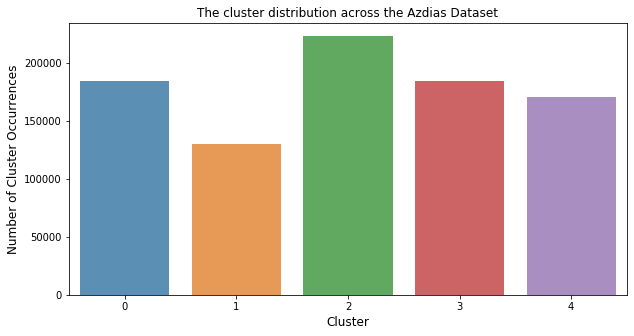

In [217]:
sorted_azdias_count  = sorted_azdias['labels'].value_counts().sort_values()
plt.figure(figsize=(10,5))
sns.barplot(sorted_azdias_count.index, sorted_azdias_count.values, alpha=0.8)
plt.title('The cluster distribution across the Azdias Dataset')
plt.ylabel('Number of Cluster Occurrences', fontsize=12)
plt.xlabel('Cluster', fontsize=12)
plt.show()

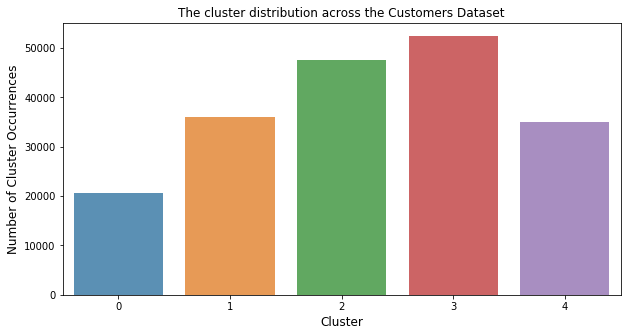

In [218]:
sorted_customers_count  = sorted_customers['labels'].value_counts().sort_values()
plt.figure(figsize=(10,5))
sns.barplot(sorted_customers_count.index, sorted_customers_count.values, alpha=0.8)
plt.title('The cluster distribution across the Customers Dataset')
plt.ylabel('Number of Cluster Occurrences', fontsize=12)
plt.xlabel('Cluster', fontsize=12)
plt.show()

In [37]:
# converting to df and assigning new names to the columns
azdias_value_counts = pd.DataFrame(sorted_azdias['labels'].value_counts())
azdias_value_counts = azdias_value_counts.reset_index()
azdias_value_counts.columns = ['clusters', 'counts'] # change column names
azdias_value_counts

,clusters,counts
0,2,222919
1,0,184453
2,3,184024
3,4,170358
4,1,129467


In [38]:
# converting to df and assigning new names to the columns
customers_value_counts = pd.DataFrame(sorted_customers['labels'].value_counts())
customers_value_counts = customers_value_counts.reset_index()
customers_value_counts.columns = ['clusters', 'counts'] # change column names
customers_value_counts

,clusters,counts
0,3,52465
1,2,47540
2,1,36078
3,4,34957
4,0,20612


In [39]:
combined = azdias_value_counts.merge(customers_value_counts, on='clusters')
combined

,clusters,counts_x,counts_y
0,2,222919,47540
1,0,184453,20612
2,3,184024,52465
3,4,170358,34957
4,1,129467,36078


In [41]:
combined = combined.rename(columns = {'counts_x': 'azdias', 'counts_y':'customers'})
combined

,clusters,azdias,customers
0,2,222919,47540
1,0,184453,20612
2,3,184024,52465
3,4,170358,34957
4,1,129467,36078


## Combined Chart for both Azdias and Customers Clusters

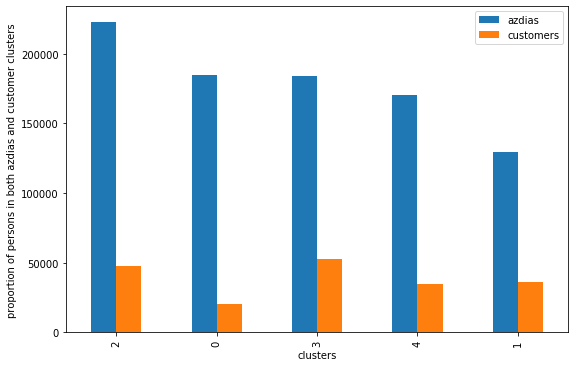

In [42]:
combined.plot(x='clusters', y = ['azdias', 'customers'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in both azdias and customer clusters')
plt.show()

## Identifying the clusters the fall under different Product Groups, Customer Groups and online purchase history

Remember that the customer dataset had three additional attributes (product group, customer group and online purchase). From the customer clusters, which when combined with these additional attributes will give us an insight into which clusters belong to each of these categories. This can now be extended to the Azdias dataset

In [49]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [53]:
data3 = customers[['LNR', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP', 'PRODUCT_GROUP']]

In [54]:
data3.head()

,LNR,ONLINE_PURCHASE,CUSTOMER_GROUP,PRODUCT_GROUP
0,9626,0,MULTI_BUYER,COSMETIC_AND_FOOD
1,9628,0,SINGLE_BUYER,FOOD
2,143872,0,MULTI_BUYER,COSMETIC_AND_FOOD
3,143873,0,MULTI_BUYER,COSMETIC
4,143874,0,MULTI_BUYER,FOOD


In [55]:
sorted_customers.head()

,LNR,343,342,341,340,339,338,337,336,335,334,333,332,331,330,329,328,327,326,325,324,323,322,321,320,319,318,317,316,315,314,313,312,311,310,309,308,307,306,305,304,303,302,301,300,299,298,297,296,295,294,293,292,291,290,289,288,287,286,285,284,283,282,281,280,279,278,277,276,275,274,273,272,271,270,269,268,267,266,265,264,263,262,261,260,259,258,257,256,255,254,253,252,251,250,249,248,247,246,245,244,labels
0,182060.0,-1.228520,-0.538319,1.747669,-0.838503,0.250587,0.101678,-0.901902,-0.485444,0.603394,-1.462854,0.266000,0.317449,-0.237855,-0.143282,0.602755,-0.047427,0.167640,0.616258,1.011198,-0.294821,-0.599674,-0.156138,0.505803,-0.611102,-0.183253,0.263181,0.141806,0.179506,0.160563,-0.128679,-0.347553,-0.325728,-0.011442,-0.038755,-0.321395,0.107231,-0.403109,0.215031,-0.211831,0.164798,0.107204,-0.131303,0.264575,-0.306227,0.189646,0.240895,0.099567,0.379222,-0.192933,0.363114,-0.422625,-0.026164,-0.112249,0.060457,0.154043,0.194052,0.261282,0.309429,-0.026032,0.299543,-0.327873,0.253925,0.247785,-0.112925,-0.245179,0.094112,-0.036550,-0.066654,-0.255233,0.049577,-0.019320,0.340959,0.298985,0.269714,0.031685,0.017160,0.060892,-0.163211,0.360942,-0.420531,-0.025152,-0.152794,-0.003761,0.469164,0.181126,0.091319,-0.036617,-0.177763,-0.157337,-0.302288,-0.195107,0.369463,0.097204,0.172167,-0.159067,0.041054,-0.041144,0.300059,0.165593,0.773558,0
1,164497.0,-0.997957,-1.167910,1.285846,-0.842893,0.146928,0.477868,0.339039,0.180128,0.724163,0.649809,0.263472,0.642531,-0.165615,0.256724,0.125584,0.176475,-0.303427,0.299137,-0.577045,0.411939,0.061045,0.506944,0.118692,-0.314957,-0.247107,0.846073,0.471259,0.504724,-0.042058,-0.277887,-0.077262,-0.007147,-0.376858,-0.195574,0.685450,-0.212184,0.572064,-0.102833,0.022114,0.144932,0.311289,0.015869,0.121771,-0.814015,0.476280,0.340550,-0.436854,0.175903,0.025249,-0.425397,0.346829,-0.446227,-0.360808,-0.064276,0.547177,-0.060106,0.097556,-0.636151,-0.326143,-0.526289,-0.127245,-0.187792,0.101636,-0.248289,-0.612798,0.100310,0.020467,0.136012,0.111313,-0.240677,-0.058426,0.144623,-0.315608,-0.234536,-0.040439,0.147204,0.251846,-0.021895,-0.247473,0.482589,0.276522,0.136341,0.048779,0.347838,0.160059,0.082396,0.183456,-0.533510,-0.062677,-0.303667,0.392571,-0.357494,0.132917,-0.327652,0.276520,0.185873,0.322328,-0.040552,-0.228779,0.103712,0
2,42697.0,-1.555475,-0.400070,1.369220,-1.091838,0.494645,0.318228,0.343232,0.161913,0.940027,-1.393106,0.570041,-0.908235,0.050227,-0.533936,-0.032834,0.065274,-0.134106,-0.001746,-0.162807,0.409378,0.030347,-0.442817,0.080698,-0.346908,0.223584,-0.125906,0.441318,0.377197,-0.087534,0.344697,-0.251201,-0.370866,0.160585,0.135138,-0.395876,-0.099609,0.278660,0.409025,-0.052320,0.905351,0.277448,0.220242,0.329265,0.455424,-0.113050,-0.069948,-0.146281,0.398482,0.120728,0.024665,-0.255436,0.112443,0.167027,-0.122702,0.539081,-0.077811,-0.038899,0.084085,-0.033234,-0.109446,0.422048,0.152783,-0.002234,-0.425688,-0.309289,-0.295377,0.059248,-0.335344,-0.529159,0.517586,0.031623,-0.070658,-0.064365,-0.080849,0.150358,0.063915,-0.334473,-0.091768,-0.321258,0.258982,-0.008939,-0.134136,0.337045,-0.292044,0.014545,0.196321,0.329668,0.101183,-0.030581,-0.170144,0.348122,-0.085909,0.015008,-0.277027,-0.092665,-0.187861,-0.037495,0.166787,-0.021384,-0.203030,0
3,124852.0,0.425162,-2.627928,2.132923,-0.530516,-1.813849,0.363259,-0.480667,-0.346097,0.259592,0.168820,0.124385,0.334489,-0.643051,-0.306877,-0.126815,-0.367254,-0.272838,0.607604,0.647028,0.108812,-0.188556,-0.059062,-0.107654,-0.157537,-0.024042,0.060948,-0.012359,0.461856,0.436462,-0.025223,-0.476234,0.077395,0.431991,0.098721,0.119621,0.576953,-0.081895,0.206638,-0.130680,-0.491062,0.282030,-0.025435,0.002701,-0.294708,0.155547,0.096509,-0.372120,-0.260843,0.389909,-0.000981,-0.081788,0.328228,-0.121557,-0.223446,-0.066533,-0.004078,-0.596449,-0.202242,-0.242129,0.071096,0.108697,-0.757063,0.295296,-0.159438,0.332428,0.234661,0.115163,-0.222512,-0.693736,0.029722,0.122648,-0.653458,-0.09192

In [56]:
data4 = sorted_customers[['LNR', 'labels']]

In [57]:
data4.head()

,LNR,labels
0,182060.0,0
1,164497.0,0
2,42697.0,0
3,124852.0,0
4,79214.0,0


In [60]:
data4['LNR'] = data4['LNR'].astype(int)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [64]:
joined = data3.merge(data4, on='LNR')
joined.head()

,LNR,ONLINE_PURCHASE,CUSTOMER_GROUP,PRODUCT_GROUP,labels
0,9626,0,MULTI_BUYER,COSMETIC_AND_FOOD,3
1,9628,0,SINGLE_BUYER,FOOD,3
2,143872,0,MULTI_BUYER,COSMETIC_AND_FOOD,4
3,143873,0,MULTI_BUYER,COSMETIC,1
4,143874,0,MULTI_BUYER,FOOD,4


In [63]:
data3.shape, data4.shape

((191652, 4), (191652, 2))

In [65]:
joined.shape

(191652, 5)

Now that the initial customer data which has online purchase, customer group and product group is now joined with the clusters, we can do further analysis to know the most important clusters which we can now extend to Azdias when there are marketing campaigns

## ONLINE PURCHASE

In [68]:
joined.groupby(['ONLINE_PURCHASE', 'labels'])['labels'].count()

ONLINE_PURCHASE  labels
0                0         19261
                 1         33064
                 2         42746
                 3         47481
                 4         31804
1                0          1351
                 1          3014
                 2          4794
                 3          4984
                 4          3153
Name: labels, dtype: int64

From the above, it appears more clusters are 0(offline purchase) and if the focus is on online purchase, it is advisable to focus more on clusters 2 and 3

## CUSTOMER GROUP

In [69]:
joined.groupby(['CUSTOMER_GROUP', 'labels'])['labels'].count()

CUSTOMER_GROUP  labels
MULTI_BUYER     0         14855
                1         24066
                2         30965
                3         37730
                4         24623
SINGLE_BUYER    0          5757
                1         12012
                2         16575
                3         14735
                4         10334
Name: labels, dtype: int64

From the above, to place emphasis on either a single buyer or a multiple buyer, the cluster with the most frequent occurences will take precedence.
- Single buyer : consider clusters 2, 3,1 in this order
- Multi buyer : consider clusters 3, 2, 4 in this order

## PRODUCT GROUP

In [70]:
joined.groupby(['PRODUCT_GROUP', 'labels'])['labels'].count()

PRODUCT_GROUP      labels
COSMETIC           0          5493
                   1          7037
                   2         11532
                   3         11723
                   4          7625
COSMETIC_AND_FOOD  0         11323
                   1         18348
                   2         23266
                   3         28942
                   4         18982
FOOD               0          3796
                   1         10693
                   2         12742
                   3         11800
                   4          8350
Name: labels, dtype: int64

The product group has three major categories: cosmetic, cosmetic and food, and food. In order to focus marketing campaigns on the type of product, it will be advisable to consider the following clusters per product offering.

- Cosmetic: consider clusters 3 and 2 in this order
- Cosmetic and food: consider clusters 3 and 2 in this order as well
- Food: consider cluster 2, 3 and 1 in this order

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [71]:
#import important libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler

from numpy import mean
import time
from numpy import std
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from matplotlib import pyplot
from catboost import *
import shap

from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

In [72]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [73]:
mailout_train = pd.read_csv('s3://datateam-ml/Arvato_project/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.


In [74]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [75]:
mailout_train.shape

(42962, 367)

In [76]:
#From the distribution below, the target variable is highly imabalanced
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [78]:
#Get the percentage proportion of clicks in the dataset. 
#It is merely above 1% of the entire dataset
ratio = (len(mailout_train[mailout_train['RESPONSE']==1])/
         len(mailout_train))*100

print(ratio)

1.2383036171500394


In [79]:
#Split the data into the attributes and target for further splitting
X = mailout_train.drop(['RESPONSE'], axis = 1)
y = mailout_train['RESPONSE'].copy()

In [80]:
#To avoid data leakage in the train and test dataset, the data was split further
#to enable that the preprocessing steps are carried out independently.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

In [81]:
X_train.shape, y_train.shape

((34369, 366), (34369,))

In [82]:
y_train.value_counts()

0    33943
1      426
Name: RESPONSE, dtype: int64

In [83]:
X_test.shape, y_test.shape

((8593, 366), (8593,))

In [84]:
y_test.value_counts()

0    8487
1     106
Name: RESPONSE, dtype: int64

In [90]:
#list(set(mailout_train.columns.tolist()) - set(azdias.columns.tolist()))

['RESPONSE']

In [85]:
%%capture
from preprocessing import clean_data
clean5 = clean_data(X_train)
clean_X_train = clean5.handle_nan()

In [86]:
clean_X_train.shape

(34369, 314)

In [87]:
X_train_dummies = pd.get_dummies(clean_X_train)

In [88]:
X_train_LNR = X_train_dummies['LNR'].copy()

In [89]:
X_train_dummies = X_train_dummies.drop(['CAMEO_DEU_2015_XX', 'LNR'], axis = 1)

In [90]:
scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_dummies))

In [91]:
X_train_scaled.columns = X_train_dummies.columns

In [92]:
X_train_scaled.shape

(34369, 356)

In [93]:
#Oversampling the minority class
smote_algo = SMOTE(sampling_strategy=0.1, random_state=0)
smote_data_X,smote_data_Y = smote_algo.fit_sample(X_train_scaled, y_train)
smote_data_X = pd.DataFrame(data=smote_data_X,columns=X_train_scaled.columns )
smote_data_Y= pd.DataFrame(data=smote_data_Y,columns=["RESPONSE"])

In [94]:
#Approach 2
#Undersampling the majority class
smote_under = RandomUnderSampler(sampling_strategy=0.2)
smote_data_X_U,smote_data_Y_U = smote_under.fit_sample(X_train_scaled, y_train)
smote_data_X_U = pd.DataFrame(data=smote_data_X_U,columns=X_train_scaled.columns )
smote_data_Y_U = pd.DataFrame(data=smote_data_Y_U,columns=["RESPONSE"])

In [95]:
#Oversampling distribution
smote_data_Y.RESPONSE.value_counts()

0    33943
1     3394
Name: RESPONSE, dtype: int64

In [96]:
#Undersampling distribution
smote_data_Y_U.RESPONSE.value_counts()

0    2130
1     426
Name: RESPONSE, dtype: int64

In [97]:
%%capture
clean6 = clean_data(X_test)
clean_X_test = clean6.handle_nan()

In [98]:
X_test_dummies = pd.get_dummies(clean_X_test)

In [99]:
X_test_LNR = X_test_dummies['LNR'].copy()

In [100]:
X_test_dummies = X_test_dummies.drop(['CAMEO_DEU_2015_XX', 'LNR'], axis = 1)

In [101]:
scaler = MinMaxScaler()

X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test_dummies))

In [102]:
X_test_scaled.columns = X_test_dummies.columns

## Modeling

In [133]:
#Using the scaled train and test dataset
class_weights = (1, sum(y_train == 0) / sum(y_train == 1))
model5 = CatBoostClassifier(num_trees = 30, 
                            max_depth = 3,
                            min_child_samples = 30,
                            verbose=0, 
                            class_weights=class_weights)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model5, X_train_scaled, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
print('Mean ROC_AUC score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model5 = CatBoostClassifier(num_trees = 30, 
                            max_depth = 3,
                            min_child_samples = 30,
                            verbose=0, 
                            class_weights=class_weights)
model5.fit(X_train_scaled, y_train)
model5.score(X_test_scaled, y_test)

Mean ROC_AUC score: 0.735 (0.035)


0.8222972186663563

In [134]:
from evaluate_predictions import evaluate
evaluate(model5, X_test_scaled, y_test)

predictions     0     1
actuals                
0            7013  1474
1              53    53

Recall:     0.500
Precision:  0.035
Accuracy:   0.822



{'TP': 53,
 'FP': 1474,
 'FN': 53,
 'TN': 7013,
 'Precision': 0.03470857891290111,
 'Recall': 0.5,
 'Accuracy': 0.8222972186663563}

In [148]:
model8 = CatBoostClassifier(verbose=0, n_estimators=300, scale_pos_weight=4, learning_rate=0.05)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model8, smote_data_X_U, smote_data_Y_U, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
print('Mean ROC_AUC score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model8 = CatBoostClassifier(verbose=0, n_estimators=300, scale_pos_weight=4, learning_rate=0.05)
model8.fit(smote_data_X_U, smote_data_Y_U)
model8.score(X_test_scaled, y_test)

Mean ROC_AUC score: 0.723 (0.038)


0.8873501687419993

In [203]:
from evaluate_predictions import evaluate
evaluate(model8, X_test_scaled, y_test)

predictions     0    1
actuals               
0            7588  899
1              69   37

Recall:     0.349
Precision:  0.040
Accuracy:   0.887



{'TP': 37,
 'FP': 899,
 'FN': 69,
 'TN': 7588,
 'Precision': 0.03952991452991453,
 'Recall': 0.3490566037735849,
 'Accuracy': 0.8873501687419993}

5.0

In [66]:
# define dataset
# evaluate the model on the oversampled minority class
model = CatBoostClassifier(verbose=0, n_estimators=300, scale_pos_weight=10, learning_rate=0.12189)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, smote_data_X, smote_data_Y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
print('Mean ROC_AUC score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = CatBoostClassifier(verbose=0, n_estimators=300, scale_pos_weight=10)
model.fit(smote_data_X, smote_data_Y)
model.score(X_test_scaled, y_test)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Mean ROC_AUC score: 0.965 (0.005)


0.8231118352147097

In [67]:
from evaluate_predictions import evaluate
evaluate(model, X_test_scaled, y_test)

predictions     0     1
actuals                
0            7053  1434
1              86    20

Recall:     0.189
Precision:  0.014
Accuracy:   0.823



{'TP': 20,
 'FP': 1434,
 'FN': 86,
 'TN': 7053,
 'Precision': 0.013755158184319119,
 'Recall': 0.18867924528301888,
 'Accuracy': 0.8231118352147097}

In [64]:
# define dataset
# evaluate the model on the undersampled majority class
model7 = CatBoostClassifier(verbose=0, n_estimators=300, scale_pos_weight=5)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model7, smote_data_X_U, smote_data_Y_U, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
print('Mean ROC_AUC score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model7 = CatBoostClassifier(verbose=0, n_estimators=300, scale_pos_weight=5)
model7.fit(smote_data_X_U, smote_data_Y_U)
model7.score(X_test_scaled, y_test)

Mean ROC_AUC score: 0.770 (0.038)


0.8339345979285465

In [65]:
from evaluate_predictions import evaluate
evaluate(model7, X_test_scaled, y_test)

predictions     0     1
actuals                
0            7113  1374
1              53    53

Recall:     0.500
Precision:  0.037
Accuracy:   0.834



{'TP': 53,
 'FP': 1374,
 'FN': 53,
 'TN': 7113,
 'Precision': 0.03714085494043448,
 'Recall': 0.5,
 'Accuracy': 0.8339345979285465}

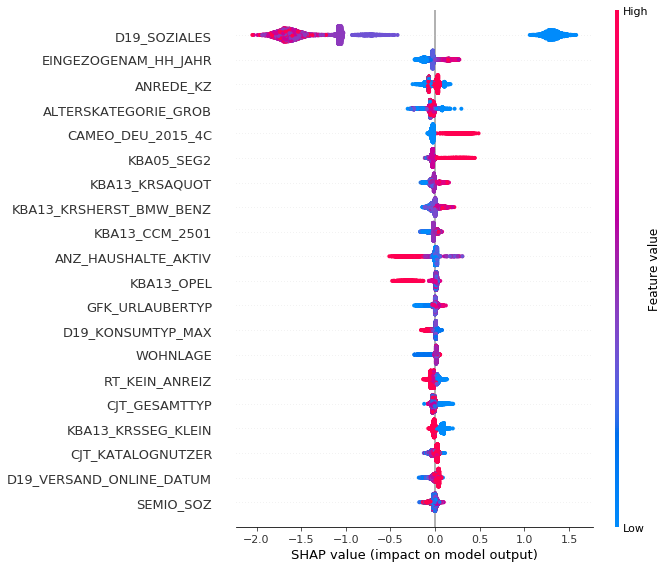

In [73]:
#Get feature importance
shap_values = model7.get_feature_importance(Pool(X_test_scaled, label=y_test), type="ShapValues")
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, X_test_scaled)

In [ ]:
#Trying without SMOTE

#XGB Hyperparameter tuning
start = time.time()

model4 = XGBClassifier(base_score=0.5, colsample_bylevel=0.5,
              colsample_bynode=0.5, colsample_bytree=0.5,
              eval_metric='auc', gamma=0.07148993933953135,
              learning_rate=0.005, max_delta_step=1, max_depth=5,
               missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=80,
              seed=None, silent=1, subsample=0.5)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model4, X_train_scaled, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
print('Mean ROC_AUC score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model4 = XGBClassifier(base_score=0.5, colsample_bylevel=0.5,
              colsample_bynode=0.5, colsample_bytree=0.5,
              eval_metric='auc', gamma=0.07148993933953135,
              learning_rate=0.005, max_delta_step=1, max_depth=5,
               missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=80,
              seed=None, silent=1, subsample=0.5)

model4.fit(X_train_scaled, y_train)
model4.score(X_test_scaled, y_test)

elapsed = time.time() - start
print("Elapsed time for running the model is: %f" % (elapsed))

In [82]:
from evaluate_predictions import evaluate
evaluate(model4, X_test_scaled, y_test)

predictions     0     1
actuals                
0            6847  1640
1              45    61

Recall:     0.575
Precision:  0.036
Accuracy:   0.804



{'TP': 61,
 'FP': 1640,
 'FN': 45,
 'TN': 6847,
 'Precision': 0.035861258083480306,
 'Recall': 0.5754716981132075,
 'Accuracy': 0.8039101594320959}

In [174]:
#Trying with SMOTE undersampling

#XGB Hyperparameter tuning
start = time.time()

model3 = XGBClassifier(base_score=0.5, colsample_bylevel=0.5,
              colsample_bynode=0.5, colsample_bytree=0.5,
              eval_metric='auc', gamma=0.05,
              learning_rate=0.01, max_delta_step=1, max_depth=5,
               missing=None, n_estimators=350, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.05, reg_lambda=1, scale_pos_weight=4,
              seed=None, silent=1, subsample=0.5)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model3, smote_data_X_U, smote_data_Y_U, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
print('Mean ROC_AUC score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model3 = XGBClassifier(base_score=0.5, colsample_bylevel=0.5,
              colsample_bynode=0.5, colsample_bytree=0.5,
              eval_metric='auc', gamma=0.05,
              learning_rate=0.01, max_delta_step=1, max_depth=5,
               missing=None, n_estimators=350, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.05, reg_lambda=1, scale_pos_weight=4,
              seed=None, silent=1, subsample=0.5)

model3.fit(smote_data_X_U, smote_data_Y_U)
model3.score(X_test_scaled, y_test)

elapsed = time.time() - start
print("Elapsed time for running the model is: %f" % (elapsed))

Mean ROC_AUC score: 0.747 (0.042)
[09:43:57] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Elapsed time for running the model is: 18.365927


In [175]:
from evaluate_predictions import evaluate
evaluate(model3, X_test_scaled, y_test)

predictions     0     1
actuals                
0            7137  1350
1              51    55

Recall:     0.519
Precision:  0.039
Accuracy:   0.837



{'TP': 55,
 'FP': 1350,
 'FN': 51,
 'TN': 7137,
 'Precision': 0.03914590747330961,
 'Recall': 0.5188679245283019,
 'Accuracy': 0.836960316536716}

In [ ]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    seed=42
)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
    'scale_pos_weight': [20, 40, 60, 80, 100]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = cv,
    verbose=True
)

grid_result = grid_search.fit(X_train_scaled, y_train)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 30 folds for each of 480 candidates, totalling 14400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 54.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 106.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 180.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 284.4min


In [88]:
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Using the entire Data to build

In [192]:
X_f = mailout_train.drop(['RESPONSE'], axis = 1)
y_f = mailout_train['RESPONSE'].copy()

In [193]:
%%capture
clean8 = clean_data(X_f)
clean_X_train_f = clean8.handle_nan()

In [194]:
X_train_dummies_f = pd.get_dummies(clean_X_train_f)
X_train_dummies_f = X_train_dummies_f.drop(['CAMEO_DEU_2015_XX', 'LNR'], axis = 1)

In [195]:
scaler = MinMaxScaler()

X_train_scaled_f = pd.DataFrame(scaler.fit_transform(X_train_dummies_f))
X_train_scaled_f.columns = X_train_dummies_f.columns

In [196]:
smote_under = RandomUnderSampler(sampling_strategy=0.2)
smote_data_X_U_f,smote_data_Y_U_f = smote_under.fit_sample(X_train_scaled_f, y_f)
smote_data_X_U_f = pd.DataFrame(data=smote_data_X_U_f,columns=X_train_scaled_f.columns )
smote_data_Y_U_f = pd.DataFrame(data=smote_data_Y_U_f,columns=["RESPONSE"])

In [210]:
#Trying with SMOTE undersampling on the whole dataset

#XGB Hyperparameter tuning
start = time.time()

model10 = XGBClassifier(base_score=0.5, colsample_bylevel=0.5,
              colsample_bynode=0.5, colsample_bytree=0.5,
              eval_metric='auc', gamma=0.05,
              learning_rate=0.01, max_delta_step=1, max_depth=5,
               missing=None, n_estimators=350, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.05, reg_lambda=1, scale_pos_weight=4,
              seed=None, silent=1, subsample=0.5)

cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3, random_state=1)
n_scores = cross_val_score(model10, smote_data_X_U_f, smote_data_Y_U_f, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
print('Mean ROC_AUC score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model10 = XGBClassifier(base_score=0.5, colsample_bylevel=0.5,
              colsample_bynode=0.5, colsample_bytree=0.5,
              eval_metric='auc', gamma=0.05,
              learning_rate=0.01, max_delta_step=1, max_depth=5,
               missing=None, n_estimators=350, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.05, reg_lambda=1, scale_pos_weight=4,
              seed=None, silent=1, subsample=0.5)

model10.fit(smote_data_X_U_f, smote_data_Y_U_f)
#model10.score(X_test_scaled, y_test)

elapsed = time.time() - start
print("Elapsed time for running the model is: %f" % (elapsed))

Mean ROC_AUC score: 0.768 (0.026)
[10:28:46] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Elapsed time for running the model is: 19.283753


In [212]:
# Using CatBoost
model11 = CatBoostClassifier(verbose=0, n_estimators=300, scale_pos_weight=5)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model11, smote_data_X_U_f, smote_data_Y_U_f, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
print('Mean ROC_AUC score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model11 = CatBoostClassifier(verbose=0, n_estimators=300, scale_pos_weight=5)
model11.fit(smote_data_X_U_f, smote_data_Y_U_f)

Mean ROC_AUC score: 0.754 (0.030)


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [176]:
mailout_test = pd.read_csv('s3://datateam-ml/Arvato_project/Udacity_MAILOUT_052018_TEST.csv', sep=';')

Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.


In [177]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [178]:
mailout_test.shape

(42833, 366)

In [77]:
list(set(mailout_train.columns.tolist()) - set(mailout_test.columns.tolist()))

['RESPONSE']

In [179]:
%%capture
clean7 = clean_data(mailout_test)
clean_mailout_test = clean7.handle_nan()

In [180]:
clean_mailout_test.shape

(42833, 314)

In [181]:
X_mailout_dummies = pd.get_dummies(clean_mailout_test)

In [182]:
X_mailout_LNR = X_mailout_dummies[['LNR']].copy()

In [183]:
X_mailout_dummies = X_mailout_dummies.drop(['CAMEO_DEU_2015_XX', 'LNR'], axis = 1)

In [184]:
scaler = MinMaxScaler()

X_mailout_scaled = pd.DataFrame(scaler.fit_transform(X_mailout_dummies))
X_mailout_scaled.columns = X_mailout_dummies.columns

In [185]:
X_mailout_scaled.shape

(42833, 356)

In [186]:
X_mailout_scaled.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BEKLEIDUNG_REST,D19_BUCH_CD,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_HAUS_DEKO,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LOTTO,D19_REISEN,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VOLLSORTIMENT,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KK_KUNDENTYP,KKK,KOMBIALTER,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELA

In [204]:
predictions = model8.predict_proba(X_mailout_scaled)[:,1]

In [205]:
# create submission csv for Kaggle
LNR = X_mailout_LNR['LNR'].astype('int32')
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0: "RESPONSE"})
csv_submission = pd.concat([LNR, predictions], sort=False, axis=1)
csv_submission.set_index('LNR', inplace = True)
csv_submission.head()

,RESPONSE
LNR,
1754,0.424134
1770,0.691061
1465,0.184492
1470,0.025344
1478,0.040157


In [206]:
csv_submission.to_csv("Kaggle_submission3.csv")